Start with modeling:
Try neural nets and other machine learning algorithms

Input data:
We want to predict future volatility -> i.e. predict the VOLQ  
 - Past volatility, i.e. past values of the VOLQ 
 - Historical returns, i.e. log diff of the NASDAQ stock price (closing price?)
 - Add sentiment later -> start without 
 - Maybe volume of stock
 - US GDP growth
 - Consumer confidence index
 - US inflation 
 - US interest rates

1. step: download needed data, 2015-2020, merge datasets into one good pandas dataframe
2. Start with modeling, try recursive neural network? maybe first try basic ones like random forest, gradient boosting etc. 
3. Evaluate models using MSE
4. Forecasting: expanding window forecasting
5. Build classifier: 
    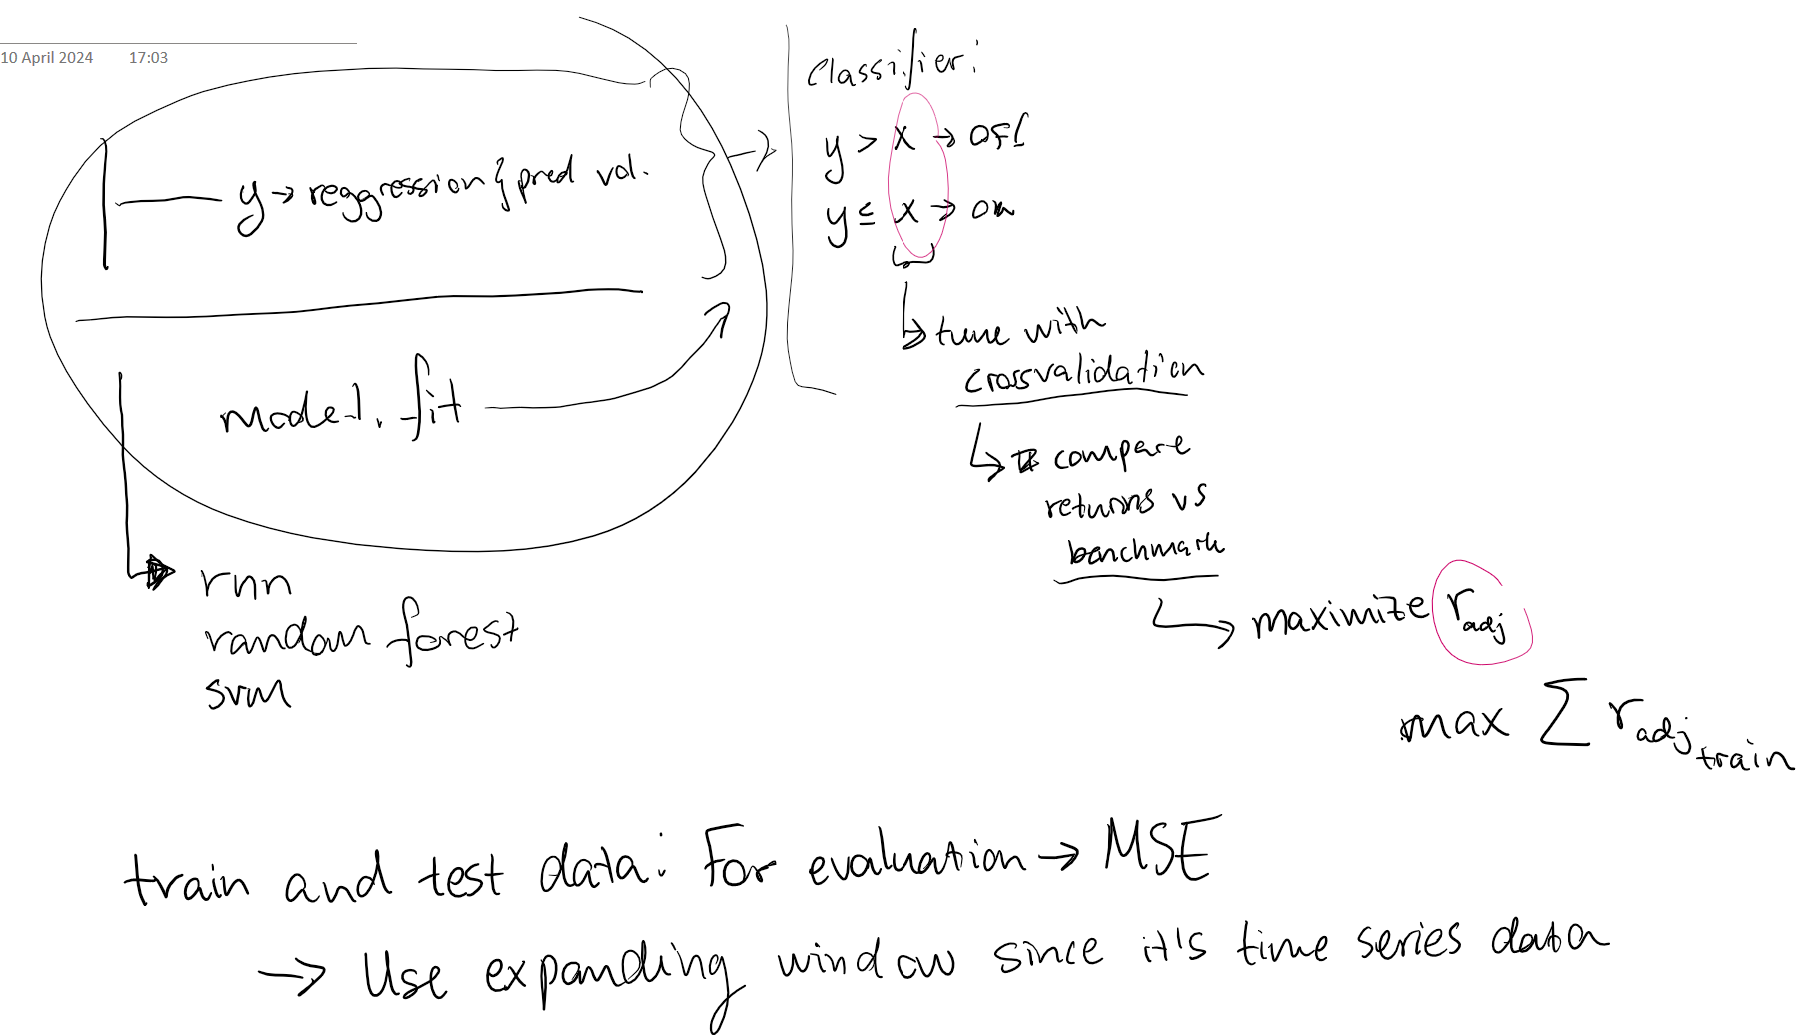
6. well see

In [21]:
#Necessary libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### First step: Data

#### Checklist: Loading data:
 - [X] VOLQ
 - [X] Price
 - [X] Volume
 - [] US GDP growth -> only quarterly data so idk if its useful
 rest is monthly data, but we can just make it daily by having each day of the month have the same value
 - [X] Interest rates 
 - [X] Inflation
 - [X] Consumer confidence index

In [22]:
#Get volatility historical data:

url_volatility = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/volatility_data.csv'
volatility_df = pd.read_csv(url_volatility)
#make the date a datetime object:
volatility_df['Date'] = pd.to_datetime(volatility_df['Date'])


In [23]:
volatility_df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
1253,2015-01-08,16.61,16.61,16.61,16.61,NaN,-3.43%
1254,2015-01-07,17.20,17.20,17.20,17.20,NaN,-9.71%
1255,2015-01-06,19.05,19.05,19.05,19.05,NaN,5.83%
1256,2015-01-05,18.00,18.00,18.00,18.00,NaN,8.50%
1257,2015-01-02,16.59,16.59,16.59,16.59,NaN,4.27%


Get the price data for the QQQ which is an ETF for the Nasdaq100 which we will use as our asset representing the nasdaq.
The ETF pays quarterly dividends, so to account for this in our calculations we have to look at the adjusted closing price instead of the raw closing price!

In [24]:
url_nasdaq_price = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/QQQ.csv'
price_df = pd.read_csv(url_nasdaq_price)
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df.head()
#this dataset includes the prices and the volume!
# we now need to calculate the returns, do this by taking the logarithm and first difference of the closing price.


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,103.760002,104.199997,102.440002,102.940002,95.704712,31314600
1,2015-01-05,102.489998,102.610001,101.139999,101.430000,94.300850,36521300
2,2015-01-06,101.580002,101.750000,99.620003,100.070000,93.036430,66205500
3,2015-01-07,100.730003,101.599998,100.489998,101.360001,94.235786,37577400
4,2015-01-08,102.220001,103.500000,102.110001,103.300003,96.039421,40212600


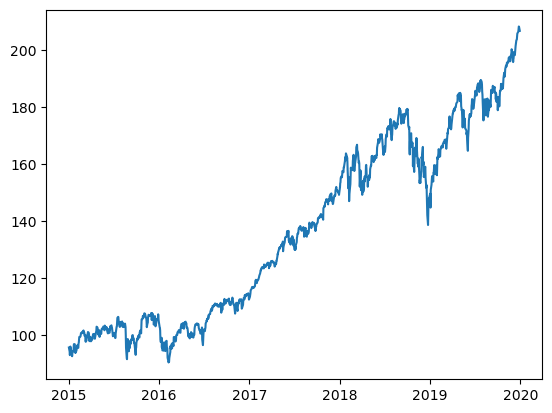

In [25]:
plt.plot(price_df['Date'], price_df['Adj Close'])

In [26]:
price_df['Returns'] = (price_df['Adj Close'] - price_df['Adj Close'].shift(1))/(price_df['Adj Close'].shift(1))*100

#drop 2014-12-31 from the data:
price_df = price_df[price_df['Date'] > '2015-01-02']
price_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Returns
1,2015-01-05,102.489998,102.610001,101.139999,101.430000,94.300850,36521300,-1.466868
2,2015-01-06,101.580002,101.750000,99.620003,100.070000,93.036430,66205500,-1.340836
3,2015-01-07,100.730003,101.599998,100.489998,101.360001,94.235786,37577400,1.289125
4,2015-01-08,102.220001,103.500000,102.110001,103.300003,96.039421,40212600,1.913960
5,2015-01-09,103.620003,103.650002,102.019997,102.620003,95.407211,41410100,-0.658282


In [27]:
# CPI data:
url_cpi = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/us_cpi_dec2014to2019.csv'
cpi_df = pd.read_csv(url_cpi)

# add monthly inflation rates (log difference like the returns)
# - not sure if log-diff is the best approach for inflation but maybe makes sense for consistency at least?

cpi_df['Log_inflation'] = np.log(cpi_df['CPIAUCSL']).diff()*100

cpi_df.head()

#now, the data is monthly but we want it to be daily, 
# so we want to extend it and just keep the same values for every day of each month:

cpi_df['DATE'] = pd.to_datetime(cpi_df['DATE'])

# Filter out the first month (December 2014)
df_filtered = cpi_df[cpi_df['DATE'] > '2014-12-01']

# Create an empty DataFrame for the daily data
daily_data = pd.DataFrame()

for _, row in df_filtered.iterrows():
    # Get the first and last day of the month
    start_date = row['DATE']
    end_date = start_date + pd.offsets.MonthEnd(1)
    
    # Generate a date range for the month
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Repeat the CPI and Log_inflation values for each day in the date range
    month_data = pd.DataFrame({
        'DATE': date_range,
        'CPIAUCSL': row['CPIAUCSL'],
        'Log_inflation': row['Log_inflation']
    })
    
    # Append the monthly data to the daily data DataFrame
    daily_data = pd.concat([daily_data, month_data], ignore_index=True)

cpi_daily_data = daily_data
cpi_daily_data.head()

,DATE,CPIAUCSL,Log_inflation
0,2015-01-01,234.747,-0.639069
1,2015-01-02,234.747,-0.639069
2,2015-01-03,234.747,-0.639069
3,2015-01-04,234.747,-0.639069
4,2015-01-05,234.747,-0.639069


In [28]:
# interest rates data

url_ir = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/US_interest_rates_historical.csv'
ir_df = pd.read_csv(url_ir)

#now, the data is monthly but we want it to be daily, 
# so we want to extend it and just keep the same values for every day of each month:

#make the date a datetime object:
ir_df['DATE'] = pd.to_datetime(ir_df['DATE'])

# Create an empty DataFrame for the daily data
daily_data = pd.DataFrame()

for _, row in ir_df.iterrows():
    # Get the first and last day of the month
    start_date = row['DATE']
    end_date = start_date + pd.offsets.MonthEnd(1)
    
    # Generate a date range for the month
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Repeat the CPI and Log_inflation values for each day in the date range
    month_data = pd.DataFrame({
        'DATE': date_range,
        'interest_rate': row['INTDSRUSM193N']
    })
    
    # Append the monthly data to the daily data DataFrame
    daily_data = pd.concat([daily_data, month_data], ignore_index=True)
ir_daily_data = daily_data
ir_daily_data.head()

,DATE,interest_rate
0,2015-01-01,0.75
1,2015-01-02,0.75
2,2015-01-03,0.75
3,2015-01-04,0.75
4,2015-01-05,0.75


In [29]:
#get consumer confidence data:
cci_url = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/consumer_barometer_US2015to2019.csv'

cci_df = pd.read_csv(cci_url)

cci_df = pd.DataFrame({'Date': cci_df['TIME_PERIOD'],
                      'consumer_barometer': cci_df['OBS_VALUE']})

cci_df['Date'] = pd.to_datetime(cci_df['Date'])

#make it daily:

# Create an empty DataFrame for the daily data
daily_data = pd.DataFrame()

for _, row in cci_df.iterrows():
    # Get the first and last day of the month
    start_date = row['Date']
    end_date = start_date + pd.offsets.MonthEnd(1)
    
    # Generate a date range for the month
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Repeat the CPI and Log_inflation values for each day in the date range
    month_data = pd.DataFrame({
        'Date': date_range,
        'consumer_barometer': row['consumer_barometer']
    })
    
    # Append the monthly data to the daily data DataFrame
    daily_data = pd.concat([daily_data, month_data], ignore_index=True)

cci_daily_data = daily_data
cci_daily_data.head()

,Date,consumer_barometer
0,2015-01-01,0.353886
1,2015-01-02,0.353886
2,2015-01-03,0.353886
3,2015-01-04,0.353886
4,2015-01-05,0.353886


In [30]:
# merge the datasets and keep only the columns of interest:

# Step 1: Standardize Date Column Names
cpi_daily_data.rename(columns={'DATE': 'Date'}, inplace=True)
ir_daily_data.rename(columns={'DATE': 'Date'}, inplace=True)

# Step 2: Merge DataFrames
# Merge volatility_df and price_df
merged_df = pd.merge(volatility_df[['Date', 'Price']], 
                     price_df[['Date', 'Returns', 'Volume']], 
                     on='Date', 
                     how='inner')

# Merge with cpi_daily_data
merged_df = pd.merge(merged_df, 
                     cpi_daily_data[['Date', 'Log_inflation']], 
                     on='Date', 
                     how='inner')

# Merge with ir_daily_data
merged_df = pd.merge(merged_df, 
                     ir_daily_data[['Date', 'interest_rate']], 
                     on='Date', 
                     how='inner')

# Merge with cci_daily_data
merged_df = pd.merge(merged_df, 
                     cci_daily_data[['Date', 'consumer_barometer']], 
                     on='Date', 
                     how='inner')

# merged_df now contains all the desired columns with matching dates


In [31]:
#rename 'Price' to 'Volatility' and more relevant column names:
merged_df.rename(columns={'Price' : 'Volatility', 'Returns' : 'stock_returns', 'Volume':'stock_volume', 'Log_inflation':'US_log_inflation', 'interest_rate':'US_interest_rate'}, inplace = True)
merged_df.head()


,Date,Volatility,stock_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer
0,2019-12-30,15.36,-0.655409,21815500,0.290799,2.25,0.196109
1,2019-12-27,14.03,-0.084185,18134100,0.290799,2.25,0.196109
2,2019-12-26,12.58,0.882400,17067500,0.290799,2.25,0.196109
3,2019-12-24,12.36,0.051936,7089000,0.290799,2.25,0.196109
4,2019-12-23,12.34,0.264144,23774700,0.290799,2.25,0.196109


In [32]:
merged_df['Date'].min()

Timestamp('2015-01-05 00:00:00')

In [33]:
#now, the first date in the dataframe is 30-12-2019, and it goes back to 2015, but we would rather
# start from the oldest date and go to the newest so we have to reverse the order of the rows:

merged_df = merged_df.iloc[::-1]

merged_df.head()

,Date,Volatility,stock_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer
1255,2015-01-05,18.00,-1.466868,36521300,-0.639069,0.75,0.353886
1254,2015-01-06,19.05,-1.340836,66205500,-0.639069,0.75,0.353886
1253,2015-01-07,17.20,1.289125,37577400,-0.639069,0.75,0.353886
1252,2015-01-08,16.61,1.913960,40212600,-0.639069,0.75,0.353886
1251,2015-01-09,16.60,-0.658282,41410100,-0.639069,0.75,0.353886


In [14]:
merged_df.tail()

,Date,Volatility,stock_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer
4,2019-12-23,12.34,0.264144,23774700,0.290799,2.25,0.196109
3,2019-12-24,12.36,0.051936,7089000,0.290799,2.25,0.196109
2,2019-12-26,12.58,0.882400,17067500,0.290799,2.25,0.196109
1,2019-12-27,14.03,-0.084185,18134100,0.290799,2.25,0.196109
0,2019-12-30,15.36,-0.655409,21815500,0.290799,2.25,0.196109


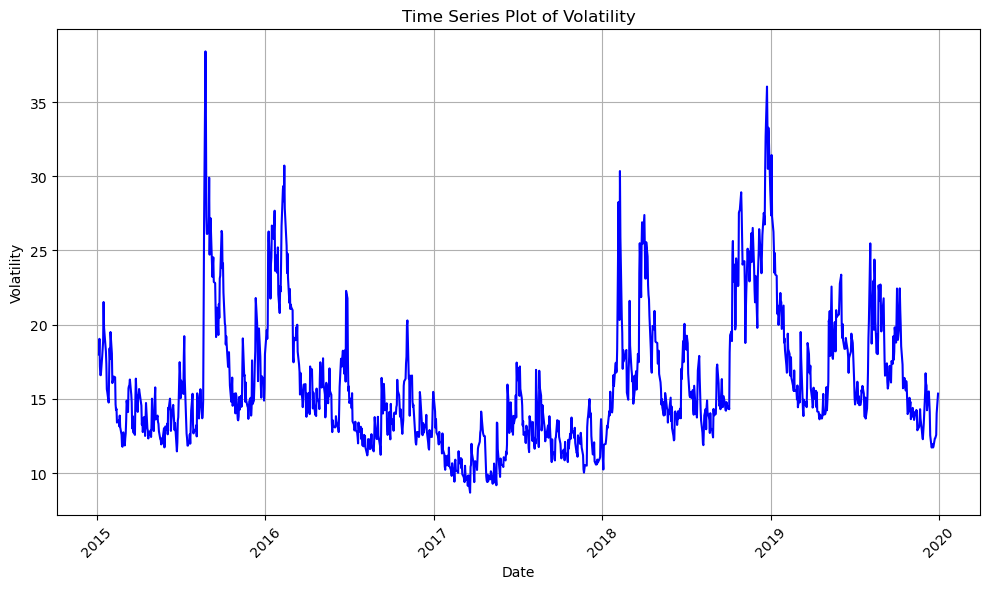

In [15]:
# Plotting the Volatility over time
plt.figure(figsize=(10, 6))  # Setting the figure size
plt.plot(merged_df['Date'], merged_df['Volatility'], linestyle='-', color='blue')  # Plotting data
#plt.axhline(16.25, color = 'red', linestyle = '--', label='Thresholds based on maximum sum of returns')
#plt.axhline(19.2, color = 'red', linestyle = '--')
#plt.axhline(14, color = 'green', linestyle = '--', label='Thresholds based on maximum average Sharpe ratio')
#plt.axhline(14.4, color = 'green', linestyle = '--')
#plt.legend()
plt.title('Time Series Plot of Volatility')  # Adding a title
plt.xlabel('Date')  # X-axis label
plt.ylabel('Volatility')  # Y-axis label
plt.grid(True)  # Adding a grid for better readability
plt.xticks(rotation=45)  # Rotating X-axis labels for better readability
plt.tight_layout()  # Adjusting the layout to make room for the rotated x-axis labels

# Displaying the plot
plt.show()

C:\Users\ingam\AppData\Local\Temp\ipykernel_22076\4156287333.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_df.corr(), annot = True, cmap='coolwarm')


<Axes: >

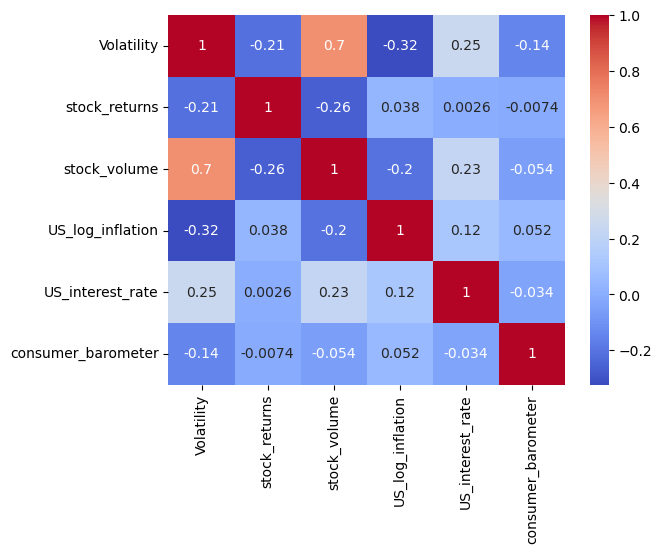

In [16]:
# look at correlation between the features:
import seaborn as sns
sns.heatmap(merged_df.corr(), annot = True, cmap='coolwarm')

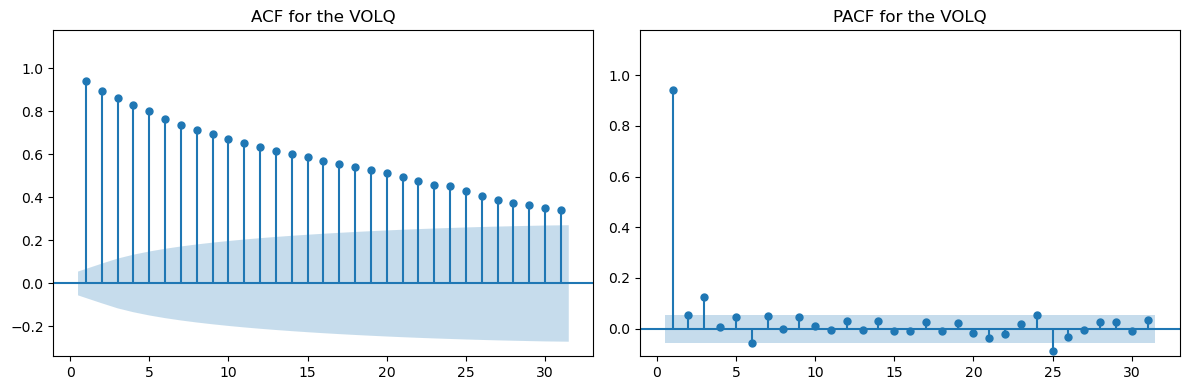

In [19]:
#look at acf and pacf of volatility to see which lags are relevant:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Create a larger figure to accommodate both subplots side by side
plt.figure(figsize=(12, 4))

# ACF plot
ax1 = plt.subplot(1, 2, 1)
plot_acf(merged_df['Volatility'], zero=False, auto_ylims=True, ax=ax1, title='ACF for the VOLQ')

# PACF plot
ax2 = plt.subplot(1, 2, 2)
plot_pacf(merged_df['Volatility'], zero=False, auto_ylims=True, ax=ax2, title='PACF for the VOLQ')

plt.tight_layout()
plt.show()


See that according to this we would pick a AR(1) process for the data, so to start modeling we will include 1 lag of the variance.

When modeling we want to use lagged values of the features, so first we can add columns that include the lags to the dataframe:

In [19]:
# #Creating Lagged Features
# lags = 1  # Number of lags
# for column in merged_df.columns.drop('Date'):
#    for lag in range(1, lags + 1):
#        merged_df[f'{column}_lag{lag}'] = merged_df[column].shift(lag)

# #Dropping rows with NaN values after shifting
# merged_df.dropna(inplace=True)

In [20]:
merged_df.head()

,Date,Volatility,stock_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer,Volatility_lag1,stock_returns_lag1,stock_volume_lag1,US_log_inflation_lag1,US_interest_rate_lag1,consumer_barometer_lag1
1254,2015-01-06,19.05,-1.340836,66205500,-0.639069,0.75,0.353886,18.00,-1.466868,36521300.0,-0.639069,0.75,0.353886
1253,2015-01-07,17.20,1.289125,37577400,-0.639069,0.75,0.353886,19.05,-1.340836,66205500.0,-0.639069,0.75,0.353886
1252,2015-01-08,16.61,1.913960,40212600,-0.639069,0.75,0.353886,17.20,1.289125,37577400.0,-0.639069,0.75,0.353886
1251,2015-01-09,16.60,-0.658282,41410100,-0.639069,0.75,0.353886,16.61,1.913960,40212600.0,-0.639069,0.75,0.353886
1250,2015-01-12,17.88,-1.042701,34129800,-0.639069,0.75,0.353886,16.60,-0.658282,41410100.0,-0.639069,0.75,0.353886


### Part 2: Modeling!!

Want to model the volatility, start maybe with models from AML assignments?:

In [21]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import BayesianRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [41]:
X_train, X_test, y_train, y_test = train_test_split(merged_df.loc[:, merged_df.columns != 'Date'], merged_df['Volatility'], test_size=0.2, shuffle=False)

In [23]:
X_train.tail()

,Volatility,stock_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer,Volatility_lag1,stock_returns_lag1,stock_volume_lag1,US_log_inflation_lag1,US_interest_rate_lag1,consumer_barometer_lag1
255,36.04,-2.479796,56163300,0.068466,3.0,0.062721,32.69,-3.099350,141129400.0,0.068466,3.0,0.062721
254,30.50,6.243867,98982100,0.068466,3.0,0.062721,36.04,-2.479796,56163300.0,0.068466,3.0,0.062721
253,33.27,0.387000,85824300,0.068466,3.0,0.062721,30.50,6.243867,98982100.0,0.068466,3.0,0.062721
252,32.54,-0.052256,77856600,0.068466,3.0,0.062721,33.27,0.387000,85824300.0,0.068466,3.0,0.062721
251,29.11,0.843285,53015300,0.068466,3.0,0.062721,32.54,-0.052256,77856600.0,0.068466,3.0,0.062721


In [24]:
X_test.head()

,Volatility,stock_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer,Volatility_lag1,stock_returns_lag1,stock_volume_lag1,US_log_inflation_lag1,US_interest_rate_lag1,consumer_barometer_lag1
250,27.36,0.401922,58576700,-0.081531,3.0,-0.556296,29.11,0.843285,53015300.0,0.068466,3.0,0.062721
249,31.43,-3.267036,74820200,-0.081531,3.0,-0.556296,27.36,0.401922,58576700.0,-0.081531,3.0,-0.556296
248,27.29,4.278461,74709300,-0.081531,3.0,-0.556296,31.43,-3.267036,74820200.0,-0.081531,3.0,-0.556296
247,26.25,1.190564,52059300,-0.081531,3.0,-0.556296,27.29,4.278461,74709300.0,-0.081531,3.0,-0.556296
246,25.11,0.904549,49388700,-0.081531,3.0,-0.556296,26.25,1.190564,52059300.0,-0.081531,3.0,-0.556296


In [25]:
X_train.columns

Index(['Volatility', 'stock_returns', 'stock_volume', 'US_log_inflation',
       'US_interest_rate', 'consumer_barometer', 'Volatility_lag1',
       'stock_returns_lag1', 'stock_volume_lag1', 'US_log_inflation_lag1',
       'US_interest_rate_lag1', 'consumer_barometer_lag1'],
      dtype='object')

In [42]:
X_train = X_train[['Volatility_lag1',
       'stock_returns_lag1', 'stock_volume_lag1', 'US_log_inflation_lag1',
       'US_interest_rate_lag1', 'consumer_barometer_lag1']]

X_test = X_test[['Volatility_lag1',
       'stock_returns_lag1', 'stock_volume_lag1', 'US_log_inflation_lag1',
       'US_interest_rate_lag1', 'consumer_barometer_lag1']]

See that the data is split so that 2019 is the test data and 2015-2018 is the training data (except for 31-12-2018...)

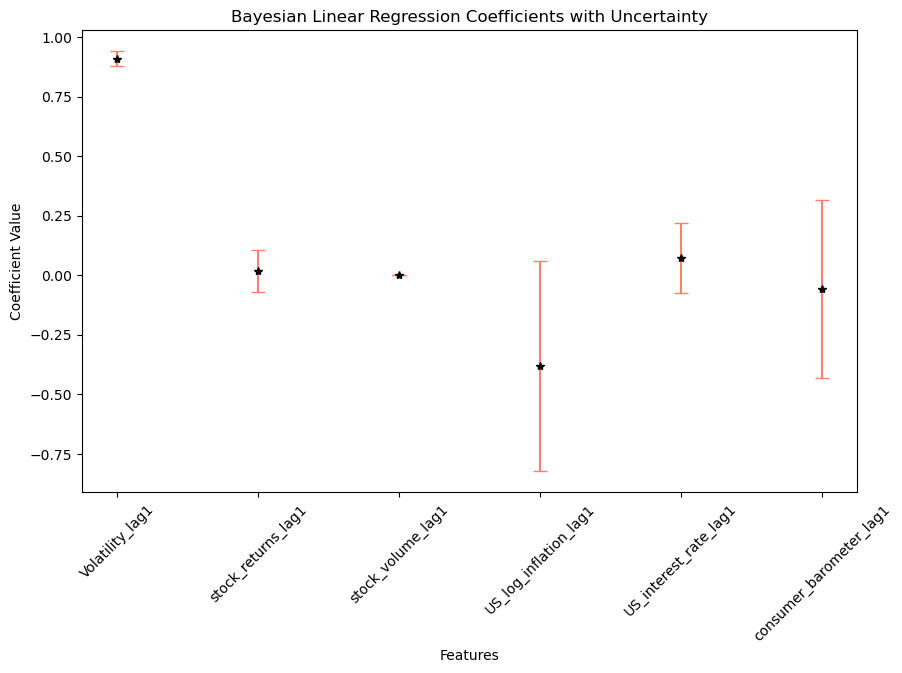

In [28]:
# Bayesian Linear Regression
bayesian_model = BayesianRidge() #stick with the default values of parameters
bayesian_model.fit(X_train.loc[:,X_train.columns != 'Volatility'], y_train)
y_pred_bayesian, y_pred_bayesian_std = bayesian_model.predict(X_test.loc[:,X_test.columns != 'Volatility'], return_std=True) #predict and return mean and std


# Extract the standard deviation of the coefficients
std_dev_coef = np.sqrt(np.diag(bayesian_model.sigma_)) #sigma contains covariacne matrix of coefficients

# Plotting the coefficient values along with standard deviation (uncertainty)
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(bayesian_model.coef_)), bayesian_model.coef_,
             yerr=1.96*std_dev_coef, # 1.96 for 95% confidence interval
             fmt='*k', # make the means stars just for fun
             ecolor='salmon', # color of error bars, salmon is prettier than red
             capsize=5)
plt.xticks(range(len(bayesian_model.coef_)), X_train.columns[X_train.columns != 'Volatility'], rotation=45)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Bayesian Linear Regression Coefficients with Uncertainty')
plt.show()

In [29]:
r2_bayes = r2_score(y_test, y_pred_bayesian)
rmse_bayes = np.sqrt(mean_squared_error(y_test, y_pred_bayesian))

print(f"R2 score: {r2_bayes}, RMSE score: {rmse_bayes}")

R2 score: 0.8306088290444393, RMSE score: 1.3576020437416019


RMSE score here now the lowest of all the models...
But: variable importance tells us that the past volatility is really the only important thing... the coefficient there is almost 1, and the coefficient for the other features is close to 0 (0 is in the 95% confidence interval...)

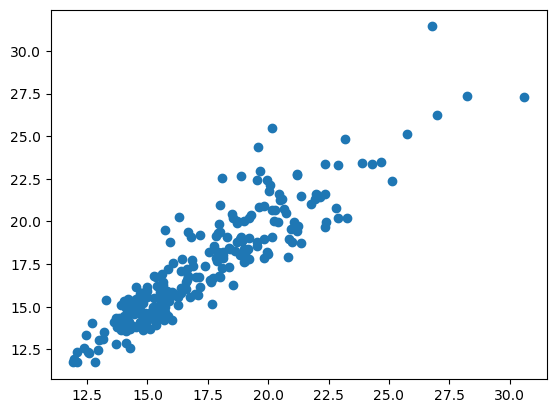

In [37]:
plt.scatter(y_pred_bayesian, y_test, )

In [35]:
#dates for test data:
test_dates = merged_df['Date'].tail(251)

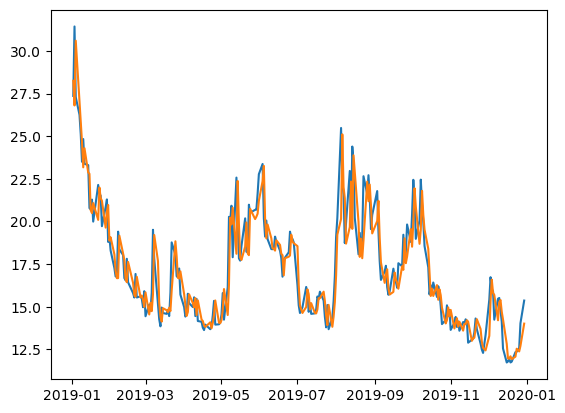

In [36]:
plt.plot(test_dates, y_test)
plt.plot(test_dates, y_pred_bayesian)

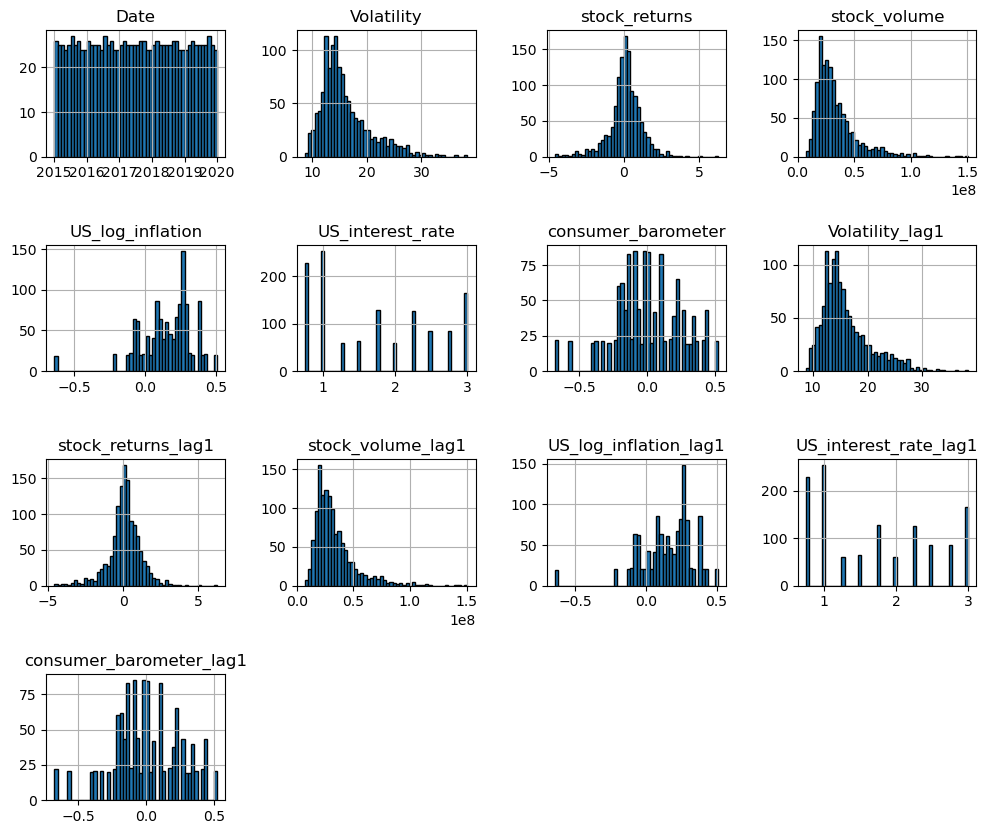

In [38]:
import seaborn as sns
merged_df.hist(figsize=(12, 10), bins=50, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

In [167]:
#!pip install xgboost

xgboost chat code model:

In [63]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np


# Initializing and training the model
model = XGBRegressor(n_estimators=45, learning_rate=0.06)
model.fit(X_train, y_train)

# Predicting and evaluating
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 1.5209510334914027


In [71]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np


# parameter grid for cv
param_grid = {
    'n_estimators': np.linspace(50,100,11).astype(int), #[50, 100, 150],
    'learning_rate': np.linspace(0.02,0.1,9), #[0.01, 0.05, 0.1],
    'max_depth': [1, 3, 5, 7]
}

model = XGBRegressor()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Best parameters: {grid_search.best_params_}")
print(f"RMSE: {rmse}")


Best parameters: {'learning_rate': 0.09000000000000001, 'max_depth': 1, 'n_estimators': 100}
RMSE: 1.5142224190753701


In [72]:
r2 = r2_score(y_test, y_pred)
r2

0.789270591647795

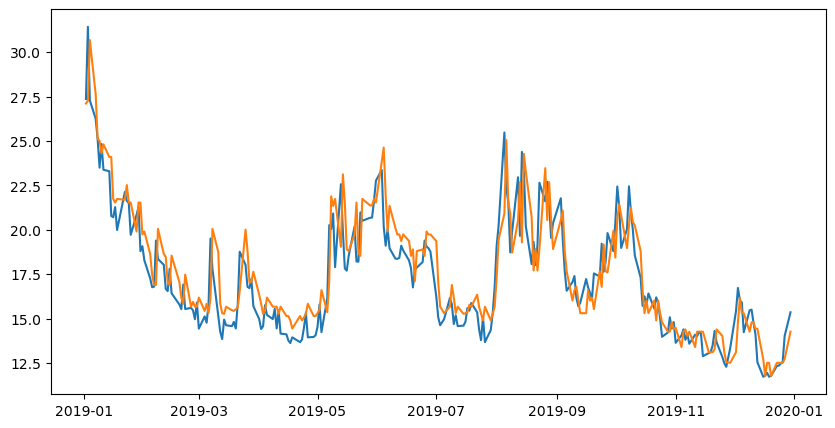

In [74]:
plt.figure(figsize=(10,5))
plt.plot(test_dates, y_test)
plt.plot(test_dates, y_pred)
plt.show()

#### RNN model:

using this article: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
as inspo/help

In [77]:
# #preprocessing: first set date as index:
# merged_df = merged_df.set_index(['Date'])

In [78]:
merged_df.head()

,Volatility,stock_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer,Volatility_lag1,stock_returns_lag1,stock_volume_lag1,US_log_inflation_lag1,US_interest_rate_lag1,consumer_barometer_lag1
Date,,,,,,,,,,,,
2015-01-06,19.05,-1.340836,66205500,-0.639069,0.75,0.353886,18.00,-1.466868,36521300.0,-0.639069,0.75,0.353886
2015-01-07,17.20,1.289125,37577400,-0.639069,0.75,0.353886,19.05,-1.340836,66205500.0,-0.639069,0.75,0.353886
2015-01-08,16.61,1.913960,40212600,-0.639069,0.75,0.353886,17.20,1.289125,37577400.0,-0.639069,0.75,0.353886
2015-01-09,16.60,-0.658282,41410100,-0.639069,0.75,0.353886,16.61,1.913960,40212600.0,-0.639069,0.75,0.353886
2015-01-12,17.88,-1.042701,34129800,-0.639069,0.75,0.353886,16.60,-0.658282,41410100.0,-0.639069,0.75,0.353886


### Try tree-based algorithms
(gradient boosting, bagging, random forest)


<Axes: >

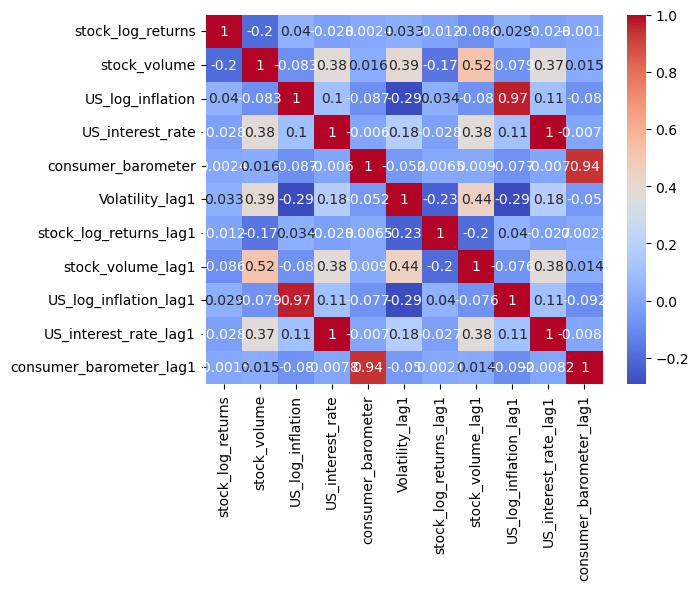

In [176]:
sns.heatmap(X_train.corr(), annot = True, cmap='coolwarm')

Next, try code from Assignment 1 AML that goes through three models and different hyperparameters using cross validation:

In [88]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV


# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30]}, #number of trees in the forest and max depth
    "AdaBoost": {'n_estimators': [10, 50, 100], 'learning_rate': [0.01, 0.1, 1]},
    "Gradient Boosting": {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [1, 3, 10]}
}

# Storing model performance
model_performance = {}
model_predictions = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]
    print(params)
    
    # Using GridSearchCV for hyperparameter tuning
    param_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=3, scoring='neg_mean_squared_error')
    param_search.fit(X_train, y_train)

    # Best model
    best_model = param_search.best_estimator_
    
    #Print the best model:
    print(best_model)
    
    # Predict on test set
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Store results
    model_performance[model_name] = {'RMSE': rmse, 
                                     'R2': r2,
                                     'Best Params': param_search.best_params_}

    # Store predictions to use for visualization:
    model_predictions[model_name] = {'y_pred' : y_pred}
    
# Output model performance
print(model_performance)

Model:   Random Forest
{'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30]}


c:\Users\ingam\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomForestRegressor(max_depth=10, random_state=42)
Model:   AdaBoost
{'n_estimators': [10, 50, 100], 'learning_rate': [0.01, 0.1, 1]}


c:\Users\ingam\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AdaBoostRegressor(learning_rate=0.01, n_estimators=10, random_state=42)
Model:   Gradient Boosting
{'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [1, 3, 10]}
GradientBoostingRegressor(max_depth=1, n_estimators=50, random_state=42)
{'Random Forest': {'RMSE': 1.5740377448802354, 'R2': 0.7722931535347624, 'Best Params': {'n_estimators': 100, 'max_depth': 10}}, 'AdaBoost': {'RMSE': 1.5522283473063991, 'R2': 0.7785595145799511, 'Best Params': {'n_estimators': 10, 'learning_rate': 0.01}}, 'Gradient Boosting': {'RMSE': 1.3897432232668319, 'R2': 0.8224932248770529, 'Best Params': {'n_estimators': 50, 'max_depth': 1, 'learning_rate': 0.1}}}


In [89]:
# Extract model prediction values for random forest, AdaBoost and gradient boosting:

y_pred_rf = model_predictions['Random Forest']['y_pred']
y_pred_ab = model_predictions['AdaBoost']['y_pred']
y_pred_gb = model_predictions['Gradient Boosting']['y_pred']

In [90]:
r2_rf = model_performance['Random Forest']['R2']
r2_ab = model_performance['AdaBoost']['R2']
r2_gb = model_performance['Gradient Boosting']['R2']

rmse_rf = model_performance['Random Forest']['RMSE']
rmse_ab = model_performance['AdaBoost']['RMSE']
rmse_gb = model_performance['Gradient Boosting']['RMSE']

In [91]:
compare_performance = {'Random Forest': f'R2: {r2_rf}, RMSE: {rmse_rf}',
                       'AdaBoost': f'R2: {r2_ab}, RMSE: {rmse_ab}',
                       'Gradient Boosting': f'R2: {r2_gb}, RMSE: {rmse_gb}',
}

model_names = ['Random Forest', 'AdaBoost', 'Gradient Boosting']

for model in model_names:
    print(model, ':', compare_performance[model])

Random Forest : R2: 0.7722931535347624, RMSE: 1.5740377448802354
AdaBoost : R2: 0.7785595145799511, RMSE: 1.5522283473063991
Gradient Boosting : R2: 0.8224932248770529, RMSE: 1.3897432232668319


Text(0.5, 1.0, 'Random Forest Predicted vs Actual values')

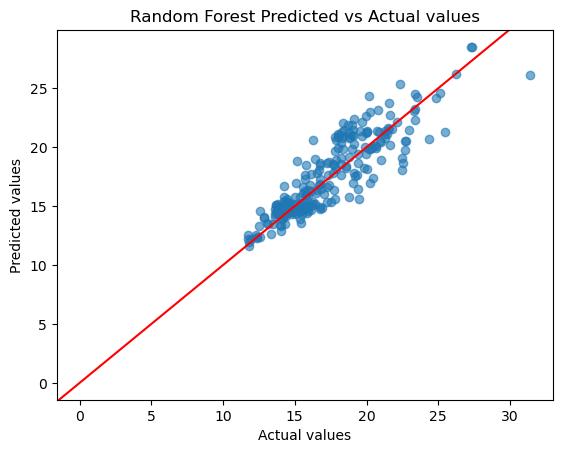

In [92]:
# Model performance : Random forest:

plt.scatter(y_test, y_pred_rf, label = 'Data points', alpha=0.6)
plt.axline((0,0), slope = 1, color = 'red')
plt.ylabel('Predicted values')
plt.xlabel('Actual values')
plt.title('Random Forest Predicted vs Actual values')

Text(0.5, 1.0, 'AdaBoost Predicted vs Actual values')

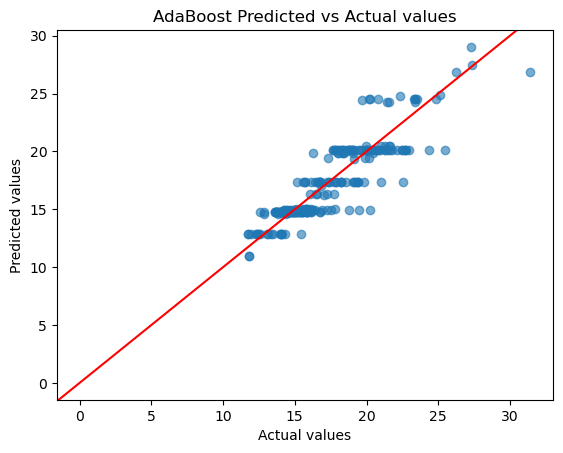

In [93]:
plt.scatter(y_test, y_pred_ab, label = 'Data points', alpha=0.6)
plt.axline((0,0), slope = 1, color = 'red')
plt.ylabel('Predicted values')
plt.xlabel('Actual values')
plt.title('AdaBoost Predicted vs Actual values')

Text(0.5, 1.0, 'Gradient Boosting Predicted vs Actual values')

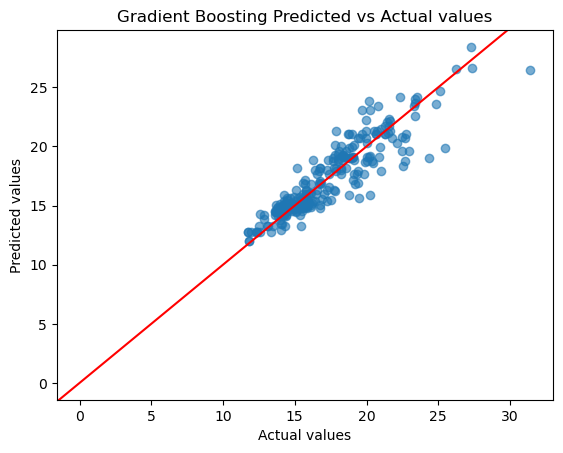

In [94]:
plt.scatter(y_test, y_pred_gb, label = 'Data points', alpha=0.6)
plt.axline((0,0), slope = 1, color = 'red')
plt.ylabel('Predicted values')
plt.xlabel('Actual values')
plt.title('Gradient Boosting Predicted vs Actual values')

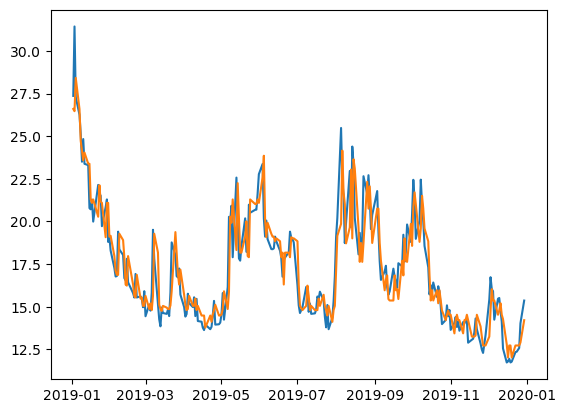

In [95]:
#plot prediction vs actual over time:
plt.plot(test_dates, y_test)
plt.plot(test_dates, y_pred_gb)
plt.show()

want to instead have it more like time series, like use expanding window forecasting, how to implement?


Now, we want to have expanding window forecasting or rolling window forecasting, start with expanding window so the following code does the same as before except now with an expanding window:

In [96]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning - use the best parameters from the code above 
parameters = {
    "Random Forest": {'n_estimators': 100, 'max_depth': 10}, #number of trees in the forest and max depth
    "AdaBoost": {'n_estimators': 50, 'learning_rate': 0.1},
    "Gradient Boosting": {'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.1}
}

# Initialize dictionaries to store results
model_performance2 = {}
model_predictions2 = {}

# Implementing expanding window forecasting
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]

    # Initialize storage for predictions and actuals
    predictions = []
    actuals = y_test.copy()  # assuming y_test is your out-of-sample data

    # Start expanding window forecast
    for i in range(len(X_test)):  # assuming X_test_lags is the test set features
        # Train model on available data
        X_train_expanding = pd.concat([X_train, X_test.iloc[:i]])
        y_train_expanding = pd.concat([y_train, y_test.iloc[:i]])
        
        # Fit the model with the best parameters (simplified for demo)
        model.set_params(**params)
        model.fit(X_train_expanding, y_train_expanding)
        
        # Make a prediction for the next point
        next_point_prediction = model.predict(X_test.iloc[[i]])
        predictions.append(next_point_prediction[0])
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    # Store results
    model_performance2[model_name] = {'RMSE': rmse, 'R2': r2}
    model_predictions2[model_name] = {'y_pred': predictions}

# Output model performance
print(model_performance2)


Model:   Random Forest
Model:   AdaBoost
Model:   Gradient Boosting
{'Random Forest': {'RMSE': 1.4533361112388408, 'R2': 0.8058765802908792}, 'AdaBoost': {'RMSE': 1.4709288590036909, 'R2': 0.8011483763358456}, 'Gradient Boosting': {'RMSE': 1.4187966330480328, 'R2': 0.8149938769133659}}


Made gradient boosting worse but made the other two better...

In [97]:
# Extract model prediction values for random forest, AdaBoost and gradient boosting:

y_pred_rf = model_predictions2['Random Forest']['y_pred']
y_pred_ab = model_predictions2['AdaBoost']['y_pred']
y_pred_gb = model_predictions2['Gradient Boosting']['y_pred']

In [98]:
r2_rf = model_performance2['Random Forest']['R2']
r2_ab = model_performance2['AdaBoost']['R2']
r2_gb = model_performance2['Gradient Boosting']['R2']

rmse_rf = model_performance2['Random Forest']['RMSE']
rmse_ab = model_performance2['AdaBoost']['RMSE']
rmse_gb = model_performance2['Gradient Boosting']['RMSE']

compare_performance = {'Random Forest': f'R2: {r2_rf}, RMSE: {rmse_rf}',
                       'AdaBoost': f'R2: {r2_ab}, RMSE: {rmse_ab}',
                       'Gradient Boosting': f'R2: {r2_gb}, RMSE: {rmse_gb}',
}

model_names = ['Random Forest', 'AdaBoost', 'Gradient Boosting']

for model in model_names:
    print(model, ':', compare_performance[model])

Random Forest : R2: 0.8058765802908792, RMSE: 1.4533361112388408
AdaBoost : R2: 0.8011483763358456, RMSE: 1.4709288590036909
Gradient Boosting : R2: 0.8149938769133659, RMSE: 1.4187966330480328


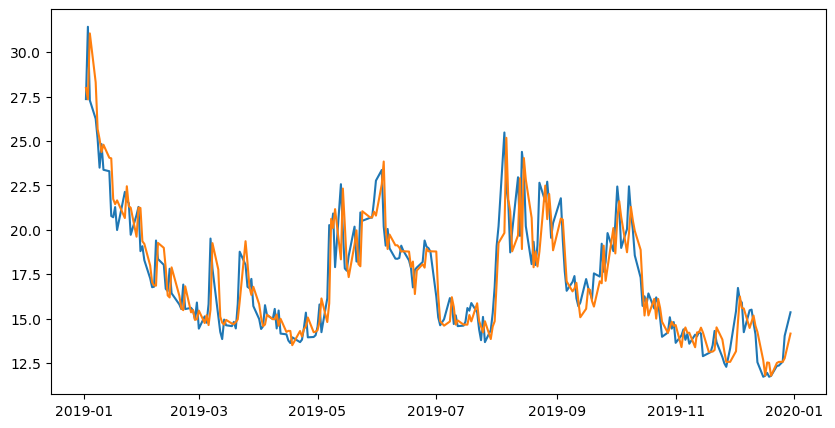

In [99]:
#plot prediction vs actual over time:
plt.figure(figsize=(10,5))
plt.plot(test_dates, y_test)
plt.plot(test_dates, y_pred_gb)
plt.show()

Now, try the same except rolling window: 
- starting with window size = 180 days, not sure what the appropriate size would be, maybe 1 year? but in the data i think we only have working days so that would be 260 days (according to google - not sure if its right)
    - For 180 the results were: 
        - 'Random Forest': {'RMSE': 1.5148793787529673, 'R2': 0.798577408671461}, 
        - 'AdaBoost': {'RMSE': 1.5171776144137281, 'R2': 0.7979657854148474}, 
        - 'Gradient Boosting': {'RMSE': 1.628777690028188, 'R2': 0.7671502932537491}}

We have 1256 rows in the data, so 1/5 of that is 252 -> use a window size of 252 to have ~1 year per window

Results for 252:
 - Random Forest : R2: 0.8039945973237811, RMSE: 1.4943694672673344
 - AdaBoost : R2: 0.7784738014524102, RMSE: 1.588680305840464
 - Gradient Boosting : R2: 0.7857951455394006, RMSE: 1.5622071414267715

In [101]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning (simplified for rolling window example)
parameters = {
    "Random Forest": {'n_estimators': 100, 'max_depth': 10}, 
    "AdaBoost": {'n_estimators': 50, 'learning_rate': 0.1},
    "Gradient Boosting": {'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.1}
}

# Initialize dictionaries to store results
model_performance2 = {}
model_predictions2 = {}

# Window size
window_size = 252  # days -> 252 is the number of days in the data / 5 (so ~the number of days per year of the data)

# Implementing rolling window forecasting
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]

    # Initialize storage for predictions and actuals
    predictions = []
    actuals = y_test.copy()  # assuming y_test is your out-of-sample data

    # Start rolling window forecast
    for i in range(len(X_test)):  # assuming X_test_lags is the test set features
        # Define the start point for the training window
        start_point = max(0, len(X_train) + i - window_size)
        end_point = len(X_train) + i

        # Train model on current window data
        X_train_rolling = pd.concat([X_train, X_test.iloc[:i]]).iloc[start_point:end_point]
        y_train_rolling = pd.concat([y_train, y_test.iloc[:i]]).iloc[start_point:end_point]
        
        # Fit the model with the best parameters (simplified for demo)
        model.set_params(**params)
        model.fit(X_train_rolling, y_train_rolling)
        
        # Make a prediction for the next point
        next_point_prediction = model.predict(X_test.iloc[[i]])
        predictions.append(next_point_prediction[0])
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    # Store results
    model_performance2[model_name] = {'RMSE': rmse, 'R2': r2}
    model_predictions2[model_name] = {'y_pred': predictions}

# Output model performance
print(model_performance2)


Model:   Random Forest
Model:   AdaBoost
Model:   Gradient Boosting
{'Random Forest': {'RMSE': 1.4470091876351001, 'R2': 0.8075630871045109}, 'AdaBoost': {'RMSE': 1.5445844124838015, 'R2': 0.7807351079518539}, 'Gradient Boosting': {'RMSE': 1.4986090214333705, 'R2': 0.7935939183898439}}


made gradient boosting way worse...

In [102]:
# Extract model prediction values for random forest, AdaBoost and gradient boosting:

y_pred_rf = model_predictions2['Random Forest']['y_pred']
y_pred_ab = model_predictions2['AdaBoost']['y_pred']
y_pred_gb = model_predictions2['Gradient Boosting']['y_pred']

In [103]:
r2_rf = model_performance2['Random Forest']['R2']
r2_ab = model_performance2['AdaBoost']['R2']
r2_gb = model_performance2['Gradient Boosting']['R2']

rmse_rf = model_performance2['Random Forest']['RMSE']
rmse_ab = model_performance2['AdaBoost']['RMSE']
rmse_gb = model_performance2['Gradient Boosting']['RMSE']

compare_performance = {'Random Forest': f'R2: {r2_rf}, RMSE: {rmse_rf}',
                       'AdaBoost': f'R2: {r2_ab}, RMSE: {rmse_ab}',
                       'Gradient Boosting': f'R2: {r2_gb}, RMSE: {rmse_gb}',
}

model_names = ['Random Forest', 'AdaBoost', 'Gradient Boosting']

for model in model_names:
    print(model, ':', compare_performance[model])

Random Forest : R2: 0.8075630871045109, RMSE: 1.4470091876351001
AdaBoost : R2: 0.7807351079518539, RMSE: 1.5445844124838015
Gradient Boosting : R2: 0.7935939183898439, RMSE: 1.4986090214333705


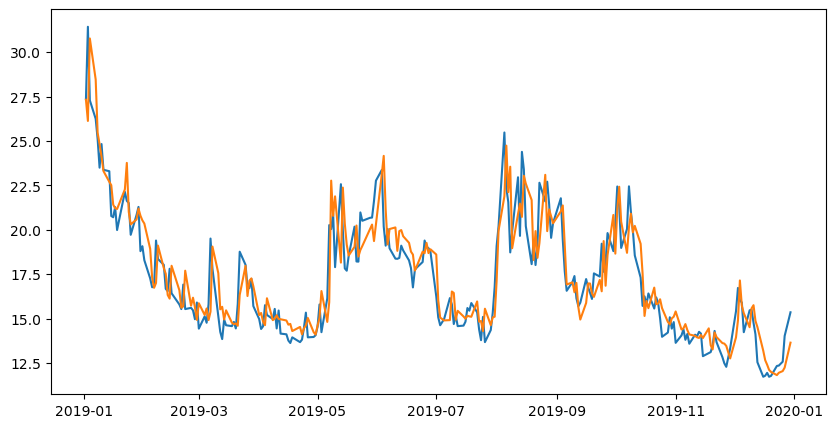

In [104]:
#plot prediction vs actual over time:
plt.figure(figsize=(10,5))
plt.plot(test_dates, y_test)
plt.plot(test_dates, y_pred_rf)
plt.show()

To make it better: go through cross validation too maybe?

Next steps: 
- Try more hyperparameters!
- try including more lags
- Build neural network
- do garch and har for benchmarking (hopefully they'll perform worse...)

In [201]:
# # do the same but with 2 lags included:

# X_train_2lags, X_test_2lags, y_train_2lags, y_test_2lags = prepare_dataset(merged_df, 'Volatility', 2)

# results = train_evaluate_models(X_train, X_test, y_train, y_test)
# results2 = train_evaluate_models(X_train_2lags, X_test_2lags, y_train_2lags, y_test_2lags)

# print(results)
# print(results2)

{'Random Forest': {'MSE': 0.7470552181746037, 'R2': 0.9344300617093173}, 'Gradient Boosting': {'MSE': 0.7877435504164324, 'R2': 0.9308587976724146}}
{'Random Forest': {'MSE': 0.7643205139043834, 'R2': 0.9297540451962386}, 'Gradient Boosting': {'MSE': 0.7009173713887551, 'R2': 0.935581200430916}}


In [202]:
# X_train_2lags = X_train_2lags[['Volatility_lag1',
#        'Volatility_lag2', 'stock_log_returns_lag1', 'stock_log_returns_lag2',
#        'stock_volume_lag1', 'stock_volume_lag2', 'US_log_inflation_lag1',
#        'US_log_inflation_lag2', 'US_interest_rate_lag1',
#        'US_interest_rate_lag2', 'consumer_barometer_lag1',
#        'consumer_barometer_lag2']]

# X_test_2lags = X_test_2lags[['Volatility_lag1',
#        'Volatility_lag2', 'stock_log_returns_lag1', 'stock_log_returns_lag2',
#        'stock_volume_lag1', 'stock_volume_lag2', 'US_log_inflation_lag1',
#        'US_log_inflation_lag2', 'US_interest_rate_lag1',
#        'US_interest_rate_lag2', 'consumer_barometer_lag1',
#        'consumer_barometer_lag2']]


In [296]:
# # Models to be used
# models = {
#     "Random Forest": RandomForestRegressor(random_state=42),
#     "AdaBoost": AdaBoostRegressor(random_state=42),
#     "Gradient Boosting": GradientBoostingRegressor(random_state=42)
# }

# # Hyperparameters for tuning - use the best parameters from the code above 
# parameters = {
#     "Random Forest": {'n_estimators': 100, 'max_depth': 10}, #number of trees in the forest and max depth
#     "AdaBoost": {'n_estimators': 50, 'learning_rate': 0.1},
#     "Gradient Boosting": {'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.1}
# }

# # Initialize dictionaries to store results
# model_performance3 = {}
# model_predictions3 = {}

# # Implementing expanding window forecasting
# for model_name in models:
#     print('Model:  ', model_name)
#     model = models[model_name]
#     params = parameters[model_name]

#     # Initialize storage for predictions and actuals
#     predictions = []
#     actuals = y_test_2lags.copy()  # assuming y_test is your out-of-sample data

#     # Start expanding window forecast
#     for i in range(len(X_test_2lags)):  # assuming X_test_lags is the test set features
#         # Train model on available data
#         X_train_expanding = pd.concat([X_train_2lags, X_test_2lags.iloc[:i]])
#         y_train_expanding = pd.concat([y_train_2lags, y_test_2lags.iloc[:i]])
        
#         # Fit the model with the best parameters (simplified for demo)
#         model.set_params(**params)
#         model.fit(X_train_expanding, y_train_expanding)
        
#         # Make a prediction for the next point
#         next_point_prediction = model.predict(X_test_2lags.iloc[[i]])
#         predictions.append(next_point_prediction[0])
    
#     # Calculate performance metrics
#     rmse = np.sqrt(mean_squared_error(actuals, predictions))
#     r2 = r2_score(actuals, predictions)

#     # Store results
#     model_performance3[model_name] = {'RMSE': rmse, 'R2': r2}
#     model_predictions3[model_name] = {'y_pred': predictions}

# # Output model performance
# print(model_performance3)


Model:   Random Forest


Model:   AdaBoost
Model:   Gradient Boosting
{'Random Forest': {'RMSE': 1.4881450102625609, 'R2': 0.7964663087278638}, 'AdaBoost': {'RMSE': 1.5209232886744515, 'R2': 0.7874013884491753}, 'Gradient Boosting': {'RMSE': 1.4386858187560476, 'R2': 0.8097705599718255}}


didnt improve performance!!

Neural network:

In [105]:
#start by scaling data:
from sklearn.preprocessing import StandardScaler

std_X = StandardScaler().fit(X_train)

X_train_lags_scaled = std_X.transform(X_train)
X_test_lags_scaled  = std_X.transform(X_test)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 128)               896       
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 11,777
Trainable params: 11,777
Non-trai

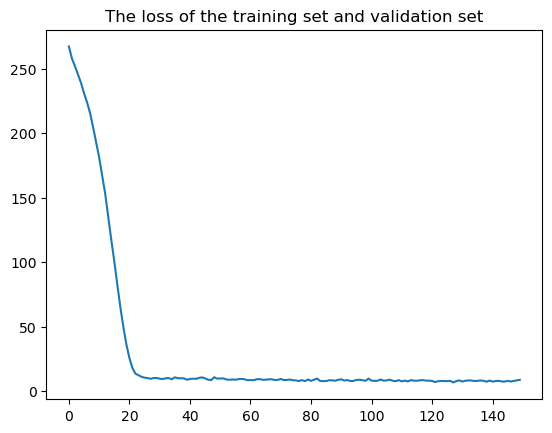

In [110]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import (Input, Dense)
# Define architecture here

model1b = keras.Sequential()

# Add layers to the model
model1b.add(Input(shape=(X_train_lags_scaled.shape[1],)))
model1b.add(Dense(128, activation = 'linear'))
#model1b.add(Dense(256, activation = 'tanh'))
#model1b.add(Dense(256, activation = 'relu'))
#model1b.add(Dense(256, activation = 'relu'))
#model1b.add(Dense(128, activation = 'linear')) #hidden layer 1
model1b.add(Dense(64, activation = 'linear')) #hidden layer 2
model1b.add(Dense(32, activation = 'linear'))
model1b.add(Dense(16, activation = 'linear'))
model1b.add(keras.layers.Dropout(0.25))
#model1b.add(Dense(8, activation = 'linear'))
#model1b.add(Dense(256, activation = 'relu'))
#model1b.add(keras.layers.Dropout(0.25))
model1b.add(Dense(1))#, activation = 'linear'))

model1b.summary()

# Compile model here
model1b.compile(loss = 'mse', optimizer = keras.optimizers.Adam(learning_rate = 1e-4))

# Fit model here
history = model1b.fit(
    x = X_train_lags_scaled,
    y = y_train,
    epochs = 150,
    batch_size = 32,
    #validation_split = 0.2,
    #callbacks = [EarlyStopping(patience = 15, monitor='val_loss')],
    shuffle = False
)

# Evaluate the model
y_pred = model1b.predict(X_test_lags_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)

plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title("The loss of the training set and validation set")
#plt.legend(["Training set","Validation set"])
plt.show()

In [111]:
# Evaluate the model
y_pred = model1b.predict(X_test_lags_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)

8/8 [==============================] - 0s 2ms/step
RMSE: 1.3888690553743004 R2: 0.8227164631251644


Epoch 1/100
32/32 [==============================] - 1s 2ms/step - loss: 239.3812
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 97.6760
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 17.1025
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 11.4596
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 7.8331
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 5.0848
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 3.8762
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 3.5658
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 3.3281
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 3.1595
Epoch 11/100
32/32 [==============================] - 0s 2ms/step - loss: 3.1333
Epoch 12/100
32/32 [==============================] - 0s 2ms/step - loss: 2.9772
Epoch 13/100
32/32 [============

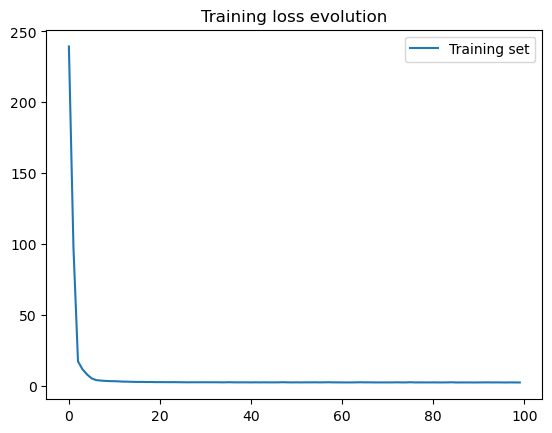

8/8 [==============================] - 0s 1ms/step
RMSE: 1.3910213968281162 R2: 0.8221665619394485


In [113]:
#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Assume X_train, y_train, X_test, y_test are already defined

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape input to be [samples, time steps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(64, activation='linear'))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))
model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


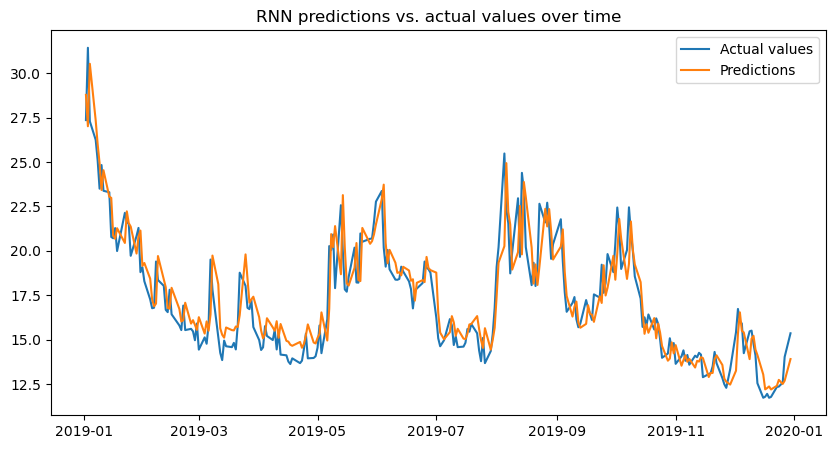

In [114]:
#plot prediction vs actual over time:
plt.figure(figsize=(10,5))
plt.plot(test_dates, y_test)
plt.plot(test_dates, y_pred)
plt.title('RNN predictions vs. actual values over time')
plt.legend(['Actual values', 'Predictions'])
plt.show()

Epoch 1/200
16/16 [==============================] - 3s 8ms/step - loss: 256.0424
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 189.2923
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 50.7773
Epoch 4/200
16/16 [==============================] - 0s 5ms/step - loss: 35.0847
Epoch 5/200
16/16 [==============================] - 0s 5ms/step - loss: 30.3477
Epoch 6/200
16/16 [==============================] - 0s 6ms/step - loss: 29.2331
Epoch 7/200
16/16 [==============================] - 0s 6ms/step - loss: 24.7305
Epoch 8/200
16/16 [==============================] - 0s 6ms/step - loss: 21.8844
Epoch 9/200
16/16 [==============================] - 0s 6ms/step - loss: 19.8504
Epoch 10/200
16/16 [==============================] - 0s 6ms/step - loss: 16.8996
Epoch 11/200
16/16 [==============================] - 0s 6ms/step - loss: 14.6769
Epoch 12/200
16/16 [==============================] - 0s 7ms/step - loss: 14.7208
Epoch 13/200
16/16 [===

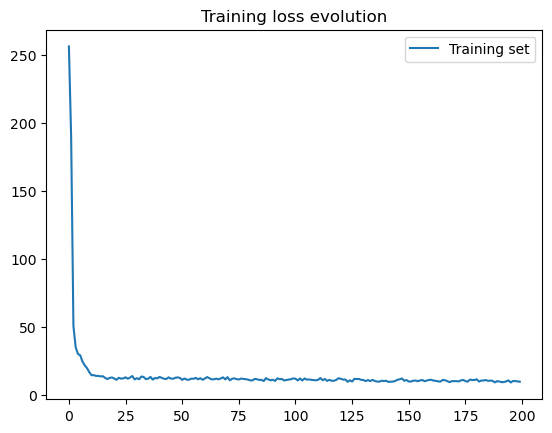

8/8 [==============================] - 0s 2ms/step
RMSE: 1.37403019016268 R2: 0.8264844687441462


In [116]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Assume X_train, y_train, X_test, y_test are already defined

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape input to be [samples, time steps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(252, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences = True))
model.add(LSTM(126, return_sequences = False))
model.add(Dense(64, activation='tanh'))
#model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_scaled, 
    y_train, 
    epochs=200, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


RMSE: 1.37403019016268 R2: 0.8264844687441462: suuper close to the garch!! 
Try to improve more:

Epoch 1/150
16/16 [==============================] - 5s 7ms/step - loss: 262.2799
Epoch 2/150
16/16 [==============================] - 0s 7ms/step - loss: 220.7559
Epoch 3/150
16/16 [==============================] - 0s 7ms/step - loss: 73.8565
Epoch 4/150
16/16 [==============================] - 0s 10ms/step - loss: 43.5307
Epoch 5/150
16/16 [==============================] - 0s 7ms/step - loss: 39.9686
Epoch 6/150
16/16 [==============================] - 0s 7ms/step - loss: 39.7933
Epoch 7/150
16/16 [==============================] - 0s 8ms/step - loss: 43.6170
Epoch 8/150
16/16 [==============================] - 0s 7ms/step - loss: 37.9976
Epoch 9/150
16/16 [==============================] - 0s 7ms/step - loss: 35.0360
Epoch 10/150
16/16 [==============================] - 0s 8ms/step - loss: 37.7319
Epoch 11/150
16/16 [==============================] - 0s 7ms/step - loss: 37.2299
Epoch 12/150
16/16 [==============================] - 0s 8ms/step - loss: 38.5279
Epoch 13/150
16/16 [==

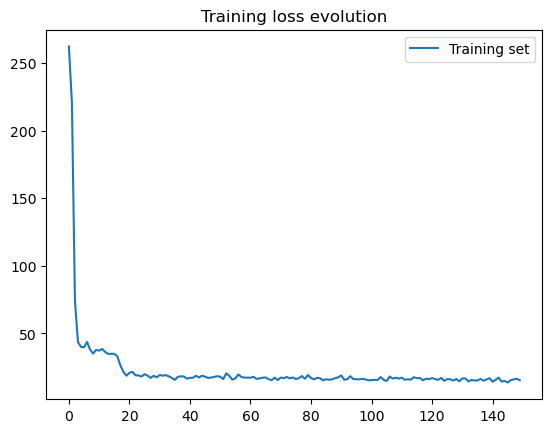

8/8 [==============================] - 1s 1ms/step
RMSE: 1.372740682250725 R2: 0.8268099996663347


In [118]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam

# Build the LSTM model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences = True))
model.add(SimpleRNN(125, return_sequences = True))
model.add(GRU(100, return_sequences = True))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_scaled, 
    y_train, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


RMSE Better than garch!!

Lower RMSE than GARCH! But also lower R2... idk why

Same but rolling window forecasting:
- tried it and it made the results worse and was way too computationally heavy so i think not relevant.

Try:
- Using the scaled data on the other models and see if that changes their results to make it comparable

GARCH:

In [122]:
#choose lags based on BIC:
import numpy as np
import pandas as pd
from arch import arch_model


# Possible values for p and q
p_values = range(1, 4)  # You can adjust these ranges based on what you consider reasonable
q_values = range(1, 4)

# Initialize variables to store the best model settings
best_bic = np.inf
best_p = None
best_q = None
best_model = None

# Grid search for the best BIC
for p in p_values:
    for q in q_values:
        model = arch_model(y_train, vol='Garch', p=p, q=q)
        fit = model.fit(disp='off')
        
        # Check if we found a new best BIC
        if fit.bic < best_bic:
            best_bic = fit.bic
            best_p = p
            best_q = q
            best_model = fit

# Output the best model's parameters and BIC
print(f"Best BIC: {best_bic} found for p={best_p} and q={best_q}")
print(best_model.summary())


Best BIC: 4753.767031581921 found for p=1 and q=1
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Volatility   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2363.06
Distribution:                  Normal   AIC:                           4734.12
Method:            Maximum Likelihood   BIC:                           4753.77
                                        No. Observations:                 1004
Date:                Tue, Apr 23 2024   Df Residuals:                     1003
Time:                        10:02:06   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            13.491

In [123]:
#look at adf test for the original series and the returns to see if maybe original was stationary:

from statsmodels.tsa.stattools import adfuller

adfuller(merged_df['Volatility'])

(-4.566242483439238,
 0.00014899667658848463,
 6,
 1248,
 {'1%': -3.4356006420838963,
  '5%': -2.8638586845641063,
  '10%': -2.5680044958343604},
 4451.311581674565)

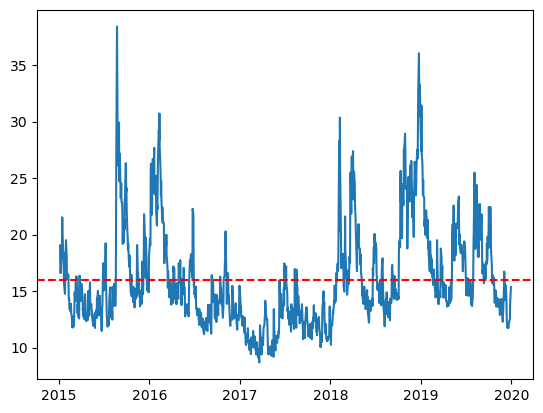

In [127]:
plt.plot(merged_df['Volatility'])
plt.axhline(merged_df['Volatility'].mean(), color = 'red', linestyle='--')

In [126]:
merged_df['Volatility'].mean()

15.952533864541833

In [128]:
adfuller(y_train)

(-3.616002341959639,
 0.005462364587623202,
 5,
 998,
 {'1%': -3.4369193380671, '5%': -2.864440383452517, '10%': -2.56831430323573},
 3582.3956727398577)

In [129]:
adfuller(y_test)

(-4.163825279579251,
 0.000758221135950767,
 0,
 250,
 {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544},
 799.3749164300717)

c:\Users\ingam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ingam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ingam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ingam\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\U

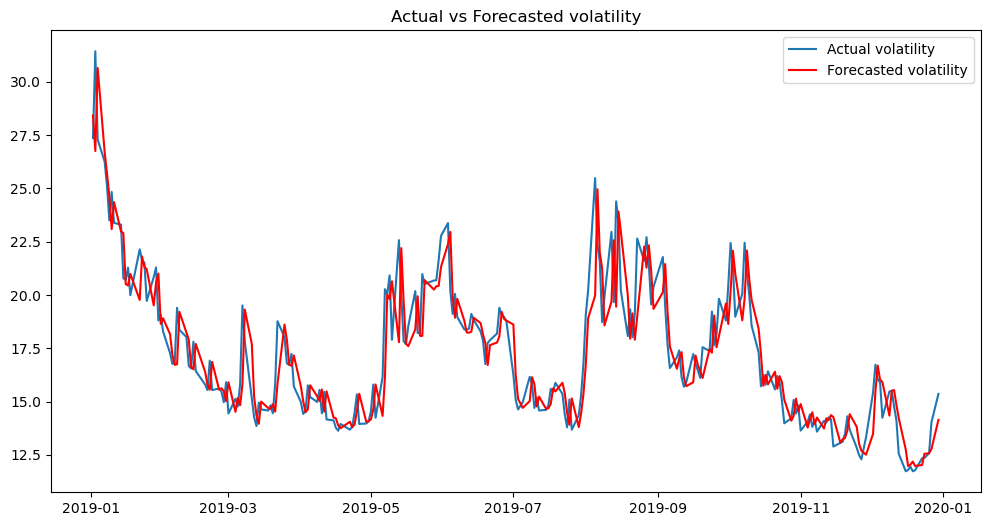

In [133]:
from statsmodels.tsa.arima.model import ARIMA
from arch.__future__ import reindexing
volatility = merged_df['Volatility']
# Set the training window size
train_size = len(y_train)

# Set forecast horizon
forecast_horizon = 1

# Initialize lists to store forecasts
mean_forecasts = []
variance_forecasts = []

for i in range(train_size, len(volatility)):
    # Training data for current window
    train_data = volatility[:i]

    # ARIMA model for mean
    arima_model = ARIMA(train_data, order=(1,0,0)) #data has ar(1) structure if we look at acf and pacf
    arima_result = arima_model.fit()
    mean_forecast = arima_result.forecast(steps=forecast_horizon)

    # GARCH model for variance
    garch_model = arch_model(train_data, vol='Garch', p=1, q=1)
    garch_result = garch_model.fit(disp='off')
    variance_forecast = garch_result.forecast(horizon=forecast_horizon).variance.values[-1, :][0]

    # Store forecasts
    mean_forecasts.append(mean_forecast)
    variance_forecasts.append(variance_forecast)

# Convert forecasts to Series for further analysis or plotting
mean_forecast_series = pd.Series(mean_forecasts, index=volatility.index[train_size:])
variance_forecast_series = pd.Series(variance_forecasts, index=volatility.index[train_size:])

# Plot the actual returns vs forecasted returns
plt.figure(figsize=(12, 6))
plt.plot(volatility.index[train_size:], volatility[train_size:], label='Actual volatility')
plt.plot(mean_forecast_series.index, mean_forecast_series, color='red', label='Forecasted volatility')
plt.legend()
plt.title('Actual vs Forecasted volatility')
plt.show()

In [134]:
np.sqrt(mean_squared_error(volatility[train_size:], mean_forecasts))

1.3721523202102688

In [135]:
r2_score(volatility[train_size:], mean_forecasts)

0.8269584276779302

We see that this result is the best out of all so far... better than all the machine learning methods.


Try boosting stuff with standardized data and see if it makes a difference:

In [136]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning (simplified for rolling window example)
parameters = {
    "Random Forest": {'n_estimators': 100, 'max_depth': 10}, 
    "AdaBoost": {'n_estimators': 50, 'learning_rate': 0.1},
    "Gradient Boosting": {'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.1}
}

# Initialize dictionaries to store results
model_performance2 = {}
model_predictions2 = {}

# Window size
window_size = 252  # days -> 252 is the number of days in the data / 5 (so ~the number of days per year of the data)

# Implementing rolling window forecasting
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]

    # Initialize storage for predictions and actuals
    predictions = []
    actuals = y_test.copy()  # assuming y_test is your out-of-sample data

    # Start rolling window forecast
    for i in range(len(X_test_lags_scaled)):  # assuming X_test_lags is the test set features
        # Define the start point for the training window
        start_point = max(0, len(X_train_lags_scaled) + i - window_size)
        end_point = len(X_train_lags_scaled) + i

        # Train model on current window data
        X_train_rolling = pd.concat([pd.DataFrame(X_train_lags_scaled), pd.DataFrame(X_test_lags_scaled).iloc[:i]]).iloc[start_point:end_point]
        y_train_rolling = pd.concat([y_train, y_test.iloc[:i]]).iloc[start_point:end_point]
        
        # Fit the model with the best parameters (simplified for demo)
        model.set_params(**params)
        model.fit(X_train_rolling, y_train_rolling)
        
        # Make a prediction for the next point
        next_point_prediction = model.predict(pd.DataFrame(X_test_lags_scaled).iloc[[i]])
        predictions.append(next_point_prediction[0])
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    # Store results
    model_performance2[model_name] = {'RMSE': rmse, 'R2': r2}
    model_predictions2[model_name] = {'y_pred': predictions}

# Output model performance
print(model_performance2)


Model:   Random Forest
Model:   AdaBoost
Model:   Gradient Boosting
{'Random Forest': {'RMSE': 1.444209067035182, 'R2': 0.808307139326359}, 'AdaBoost': {'RMSE': 1.5437049392032218, 'R2': 0.7809847320090636}, 'Gradient Boosting': {'RMSE': 1.4957509871596384, 'R2': 0.7943804519363021}}


Want to try to experiment with more hyperparameters for the boosting algorithms:

In [137]:
# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'n_estimators': range(70,80), 'max_depth': range(1,5)}, #number of trees in the forest and max depth
    "Gradient Boosting": {'n_estimators': range(75,85), 'learning_rate': np.linspace(0.08,0.12,10), 'max_depth': [1, 2, 3]}
}

# Storing model performance
model_performance2 = {}
model_predictions2 = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]
    print(params)
    
    # Using GridSearchCV for hyperparameter tuning
    param_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5, scoring='neg_mean_squared_error')
    param_search.fit(X_train, y_train)

    # Best model
    best_model = param_search.best_estimator_
    
    #Print the best model:
    print(best_model)
    
    # Predict on test set
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Store results
    model_performance2[model_name] = {'RMSE': rmse, 
                                     'R2': r2,
                                     'Best Params': param_search.best_params_}

    # Store predictions to use for visualization:
    model_predictions2[model_name] = {'y_pred' : y_pred}
    
# Output model performance
print(model_performance2)

Model:   Random Forest
{'n_estimators': range(70, 80), 'max_depth': range(1, 5)}
RandomForestRegressor(max_depth=4, n_estimators=77, random_state=42)
Model:   Gradient Boosting
{'n_estimators': range(75, 85), 'learning_rate': array([0.08      , 0.08444444, 0.08888889, 0.09333333, 0.09777778,
       0.10222222, 0.10666667, 0.11111111, 0.11555556, 0.12      ]), 'max_depth': [1, 2, 3]}
GradientBoostingRegressor(learning_rate=0.08, max_depth=2, n_estimators=77,
                          random_state=42)
{'Random Forest': {'RMSE': 1.4153908275162137, 'R2': 0.8158810211240277, 'Best Params': {'n_estimators': 77, 'max_depth': 4}}, 'Gradient Boosting': {'RMSE': 1.4797867323493579, 'R2': 0.7987462125153022, 'Best Params': {'n_estimators': 77, 'max_depth': 2, 'learning_rate': 0.08}}}


what to compare to:
- 'Random Forest': 
    - 'RMSE': 1.597527401334584, 
    - 'R2': 0.7759996466435833, 
    - 'Best Params': {'n_estimators': 100, 'max_depth': 10}
- 'Gradient Boosting': 
    - 'RMSE': 1.7759175737543775, 
    - 'R2': 0.7231798618691797, 
    - 'Best Params': {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}

In [139]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning (simplified for rolling window example)
parameters = {
    "Random Forest": {'n_estimators': 75, 'max_depth': 4}, 
    "Gradient Boosting": {'n_estimators': 84, 'max_depth': 2, 'learning_rate': 0.10222222222222221}
}

# Initialize dictionaries to store results
model_performance2 = {}
model_predictions2 = {}

# Window size
window_size = 252  # days -> 252 is the number of days in the data / 5 (so ~the number of days per year of the data)

# Implementing rolling window forecasting
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]

    # Initialize storage for predictions and actuals
    predictions = []
    actuals = y_test.copy()  # assuming y_test is your out-of-sample data

    # Start rolling window forecast
    for i in range(len(X_test_lags_scaled)):  # assuming X_test_lags is the test set features
        # Define the start point for the training window
        start_point = max(0, len(X_train_lags_scaled) + i - window_size)
        end_point = len(X_train_lags_scaled) + i

        # Train model on current window data
        X_train_rolling = pd.concat([pd.DataFrame(X_train_lags_scaled), pd.DataFrame(X_test_lags_scaled).iloc[:i]]).iloc[start_point:end_point]
        y_train_rolling = pd.concat([y_train, y_test.iloc[:i]]).iloc[start_point:end_point]
        
        # Fit the model with the best parameters (simplified for demo)
        model.set_params(**params)
        model.fit(X_train_rolling, y_train_rolling)
        
        # Make a prediction for the next point
        next_point_prediction = model.predict(pd.DataFrame(X_test_lags_scaled).iloc[[i]])
        predictions.append(next_point_prediction[0])
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    # Store results
    model_performance2[model_name] = {'RMSE': rmse, 'R2': r2}
    model_predictions2[model_name] = {'y_pred': predictions}

# Output model performance
print(model_performance2)


Model:   Random Forest
Model:   Gradient Boosting
{'Random Forest': {'RMSE': 1.4081346322211914, 'R2': 0.8177640044531527}, 'Gradient Boosting': {'RMSE': 1.5320742470820812, 'R2': 0.7842725405347606}}


In [140]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning (simplified for rolling window example)
parameters = {
    "Random Forest": {'n_estimators': 75, 'max_depth': 4}, 
    "Gradient Boosting": {'n_estimators': 76, 'max_depth': 1, 'learning_rate': 0.10857142857142857}
}

# Initialize dictionaries to store results
model_performance3 = {}
model_predictions2 = {}

# Window size
window_size = 252  # days -> 252 is the number of days in the data / 5 (so ~the number of days per year of the data)

# Implementing rolling window forecasting
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]

    # Initialize storage for predictions and actuals
    predictions = []
    actuals = y_test.copy()  # assuming y_test is your out-of-sample data

    # Start rolling window forecast
    for i in range(len(X_test_lags_scaled)):  # assuming X_test_lags is the test set features
        # Define the start point for the training window
        start_point = max(0, len(X_train_lags_scaled) + i - window_size)
        end_point = len(X_train_lags_scaled) + i

        # Train model on current window data
        X_train_rolling = pd.concat([pd.DataFrame(X_train_lags_scaled), pd.DataFrame(X_test_lags_scaled).iloc[:i]]).iloc[start_point:end_point]
        y_train_rolling = pd.concat([y_train, y_test.iloc[:i]]).iloc[start_point:end_point]
        
        # Fit the model with the best parameters (simplified for demo)
        model.set_params(**params)
        model.fit(X_train_rolling, y_train_rolling)
        
        # Make a prediction for the next point
        next_point_prediction = model.predict(pd.DataFrame(X_test_lags_scaled).iloc[[i]])
        predictions.append(next_point_prediction[0])
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    # Store results
    model_performance3[model_name] = {'RMSE': rmse, 'R2': r2}
    model_predictions2[model_name] = {'y_pred': predictions}

# Output model performance
print(model_performance3)


Model:   Random Forest
Model:   Gradient Boosting
{'Random Forest': {'RMSE': 1.4081346322211914, 'R2': 0.8177640044531527}, 'Gradient Boosting': {'RMSE': 1.457196006297486, 'R2': 0.8048440716438792}}


In [141]:
display(model_performance3)
display(model_performance2)


{'Random Forest': {'RMSE': 1.4081346322211914, 'R2': 0.8177640044531527},
 'Gradient Boosting': {'RMSE': 1.457196006297486, 'R2': 0.8048440716438792}}

{'Random Forest': {'RMSE': 1.4081346322211914, 'R2': 0.8177640044531527},
 'Gradient Boosting': {'RMSE': 1.5320742470820812, 'R2': 0.7842725405347606}}

Try: Running models without the monthly data stuff (interest rates inflation etc.)
-> see if that stuff is messing with the result

In [142]:
merged_df.head()

,Volatility,stock_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer,Volatility_lag1,stock_returns_lag1,stock_volume_lag1,US_log_inflation_lag1,US_interest_rate_lag1,consumer_barometer_lag1
Date,,,,,,,,,,,,
2015-01-06,19.05,-1.340836,66205500,-0.639069,0.75,0.353886,18.00,-1.466868,36521300.0,-0.639069,0.75,0.353886
2015-01-07,17.20,1.289125,37577400,-0.639069,0.75,0.353886,19.05,-1.340836,66205500.0,-0.639069,0.75,0.353886
2015-01-08,16.61,1.913960,40212600,-0.639069,0.75,0.353886,17.20,1.289125,37577400.0,-0.639069,0.75,0.353886
2015-01-09,16.60,-0.658282,41410100,-0.639069,0.75,0.353886,16.61,1.913960,40212600.0,-0.639069,0.75,0.353886
2015-01-12,17.88,-1.042701,34129800,-0.639069,0.75,0.353886,16.60,-0.658282,41410100.0,-0.639069,0.75,0.353886


In [144]:
#new datasets that only include the data that was actually daily:
# Just: volatility itself, stock log returns and stock volume

X_train_daily = X_train[['Volatility_lag1', 'stock_returns_lag1', 'stock_volume_lag1']]
X_test_daily = X_test[['Volatility_lag1', 'stock_returns_lag1', 'stock_volume_lag1']]

In [145]:
#train tree-based methods again and see difference in results:

# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning (simplified for rolling window example)
parameters = {
    "Random Forest": {'n_estimators': 75, 'max_depth': 4}, 
    "Gradient Boosting": {'n_estimators': 76, 'max_depth': 1, 'learning_rate': 0.10857142857142857}
}

# Initialize dictionaries to store results
model_performance3 = {}
model_predictions2 = {}

# Window size
window_size = 252  # days -> 252 is the number of days in the data / 5 (so ~the number of days per year of the data)

# Implementing rolling window forecasting
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]

    # Initialize storage for predictions and actuals
    predictions = []
    actuals = y_test.copy()  # assuming y_test is your out-of-sample data

    # Start rolling window forecast
    for i in range(len(X_test_daily)):  # assuming X_test_lags is the test set features
        # Define the start point for the training window
        start_point = max(0, len(X_train_daily) + i - window_size)
        end_point = len(X_train_daily) + i

        # Train model on current window data
        X_train_rolling = pd.concat([pd.DataFrame(X_train_daily), pd.DataFrame(X_test_daily).iloc[:i]]).iloc[start_point:end_point]
        y_train_rolling = pd.concat([y_train, y_test.iloc[:i]]).iloc[start_point:end_point]
        
        # Fit the model with the best parameters (simplified for demo)
        model.set_params(**params)
        model.fit(X_train_rolling, y_train_rolling)
        
        # Make a prediction for the next point
        next_point_prediction = model.predict(pd.DataFrame(X_test_daily).iloc[[i]])
        predictions.append(next_point_prediction[0])
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    # Store results
    model_performance3[model_name] = {'RMSE': rmse, 'R2': r2}
    model_predictions2[model_name] = {'y_pred': predictions}

# Output model performance
print(model_performance3)


Model:   Random Forest
Model:   Gradient Boosting
{'Random Forest': {'RMSE': 1.4586253599647625, 'R2': 0.8044610296245325}, 'Gradient Boosting': {'RMSE': 1.4402611684083557, 'R2': 0.8093537324049449}}


In [146]:
# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'n_estimators': range(70,80), 'max_depth': range(1,5)}, #number of trees in the forest and max depth
    "Gradient Boosting": {'n_estimators': range(75,85), 'learning_rate': np.linspace(0.08,0.12,10), 'max_depth': [1, 2, 3]}
}

# Storing model performance
model_performance2 = {}
model_predictions2 = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]
    print(params)
    
    # Using GridSearchCV for hyperparameter tuning
    param_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5, scoring='neg_mean_squared_error')
    param_search.fit(X_train_daily, y_train)

    # Best model
    best_model = param_search.best_estimator_
    
    #Print the best model:
    print(best_model)
    
    # Predict on test set
    y_pred = best_model.predict(X_test_daily)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Store results
    model_performance2[model_name] = {'RMSE': rmse, 
                                     'R2': r2,
                                     'Best Params': param_search.best_params_}

    # Store predictions to use for visualization:
    model_predictions2[model_name] = {'y_pred' : y_pred}
    
# Output model performance
print(model_performance2)

Model:   Random Forest
{'n_estimators': range(70, 80), 'max_depth': range(1, 5)}
RandomForestRegressor(max_depth=4, n_estimators=76, random_state=42)
Model:   Gradient Boosting
{'n_estimators': range(75, 85), 'learning_rate': array([0.08      , 0.08444444, 0.08888889, 0.09333333, 0.09777778,
       0.10222222, 0.10666667, 0.11111111, 0.11555556, 0.12      ]), 'max_depth': [1, 2, 3]}
GradientBoostingRegressor(learning_rate=0.08444444444444445, max_depth=2,
                          n_estimators=75, random_state=42)
{'Random Forest': {'RMSE': 1.4125506501025622, 'R2': 0.8166192001327193, 'Best Params': {'n_estimators': 76, 'max_depth': 4}}, 'Gradient Boosting': {'RMSE': 1.422478590787716, 'R2': 0.8140324021094257, 'Best Params': {'n_estimators': 75, 'max_depth': 2, 'learning_rate': 0.08444444444444445}}}


Epoch 1/25
16/16 [==============================] - 3s 7ms/step - loss: 260.0826
Epoch 2/25
16/16 [==============================] - 0s 7ms/step - loss: 235.1720
Epoch 3/25
16/16 [==============================] - 0s 7ms/step - loss: 168.0798
Epoch 4/25
16/16 [==============================] - 0s 7ms/step - loss: 63.4788
Epoch 5/25
16/16 [==============================] - 0s 6ms/step - loss: 12.1180
Epoch 6/25
16/16 [==============================] - 0s 7ms/step - loss: 9.9369
Epoch 7/25
16/16 [==============================] - 0s 7ms/step - loss: 8.1769
Epoch 8/25
16/16 [==============================] - 0s 6ms/step - loss: 7.0531
Epoch 9/25
16/16 [==============================] - 0s 6ms/step - loss: 5.9972
Epoch 10/25
16/16 [==============================] - 0s 6ms/step - loss: 5.0496
Epoch 11/25
16/16 [==============================] - 0s 7ms/step - loss: 4.3696
Epoch 12/25
16/16 [==============================] - 0s 7ms/step - loss: 3.8665
Epoch 13/25
16/16 [======================

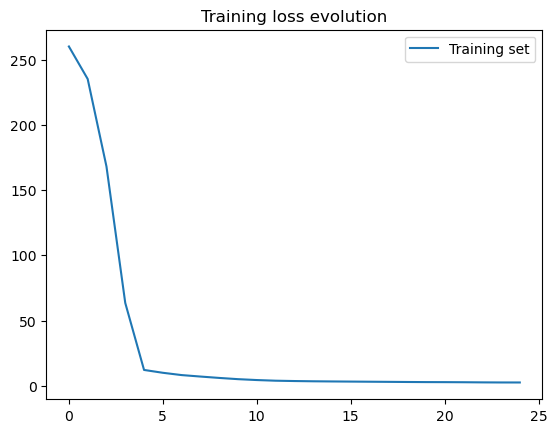

8/8 [==============================] - 0s 3ms/step
RMSE: 1.4226235786725692 R2: 0.813994490223841


In [147]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam

# Assume X_train, y_train, X_test, y_test are already defined

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_train_daily)
X_test_daily_scaled = scaler.transform(X_test_daily)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(252, activation='relu', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
model.add(SimpleRNN(100, return_sequences = False))
#model.add(GRU(100, return_sequences = True))
#model.add(LSTM(50, return_sequences = False))
#model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='tanh'))
#model.add(Dense(16, activation='relu'))
#model.add(Dropout(0.25))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train, 
    epochs=25, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


In [148]:
#try: adding the movement of the volatility to the features? Like: np.log(df).diff()?
X_train_daily_2 = X_train_daily.copy()
X_train_daily_2['Volatility_lag1_diff'] = np.log(X_train_daily_2['Volatility_lag1']).diff()

In [149]:
#try: adding the movement of the volatility to the features? Like: np.log(df).diff()?
X_test_daily_2 = X_test_daily.copy()
X_test_daily_2['Volatility_lag1_diff'] = np.log(X_test_daily_2['Volatility_lag1']).diff()
X_test_daily_2 = X_test_daily_2.dropna()

In [150]:
X_train_daily_2 = X_train_daily_2.dropna()

In [151]:
X_train_daily_2

,Volatility_lag1,stock_returns_lag1,stock_volume_lag1,Volatility_lag1_diff
1253,19.05,-1.340836,66205500.0,0.056695
1252,17.20,1.289125,37577400.0,-0.102158
1251,16.61,1.913960,40212600.0,-0.034904
1250,16.60,-0.658282,41410100.0,-0.000602
1249,17.88,-1.042701,34129800.0,0.074280
...,...,...,...,...
255,32.69,-3.099350,141129400.0,0.072956
254,36.04,-2.479796,56163300.0,0.097560
253,30.50,6.243867,98982100.0,-0.166903
252,33.27,0.387000,85824300.0,0.086929


In [159]:
# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'n_estimators': range(70,80), 'max_depth': range(1,5)}, #number of trees in the forest and max depth
    "Gradient Boosting": {'n_estimators': range(75,85), 'learning_rate': np.linspace(0.08,0.12,10), 'max_depth': [1, 2, 3]}
}

# Storing model performance
model_performance2 = {}
model_predictions2 = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]
    print(params)
    
    # Using GridSearchCV for hyperparameter tuning
    param_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5, scoring='neg_mean_squared_error')
    param_search.fit(X_train_daily_2, y_train[1:])

    # Best model
    best_model = param_search.best_estimator_
    
    #Print the best model:
    print(best_model)
    
    # Predict on test set
    y_pred = best_model.predict(X_test_daily_2)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test[1:], y_pred))
    r2 = r2_score(y_test[1:], y_pred)

    # Store results
    model_performance2[model_name] = {'RMSE': rmse, 
                                     'R2': r2,
                                     'Best Params': param_search.best_params_}

    # Store predictions to use for visualization:
    model_predictions2[model_name] = {'y_pred' : y_pred}
    
# Output model performance
print(model_performance2)

Model:   Random Forest
{'n_estimators': range(70, 80), 'max_depth': range(1, 5)}
RandomForestRegressor(max_depth=4, n_estimators=79, random_state=42)
Model:   Gradient Boosting
{'n_estimators': range(75, 85), 'learning_rate': array([0.08      , 0.08444444, 0.08888889, 0.09333333, 0.09777778,
       0.10222222, 0.10666667, 0.11111111, 0.11555556, 0.12      ]), 'max_depth': [1, 2, 3]}
GradientBoostingRegressor(learning_rate=0.12, max_depth=2, n_estimators=82,
                          random_state=42)
{'Random Forest': {'RMSE': 1.4095884789594155, 'R2': 0.8110161805666414, 'Best Params': {'n_estimators': 79, 'max_depth': 4}}, 'Gradient Boosting': {'RMSE': 1.4552324698959906, 'R2': 0.7985790259530583, 'Best Params': {'n_estimators': 82, 'max_depth': 2, 'learning_rate': 0.12}}}


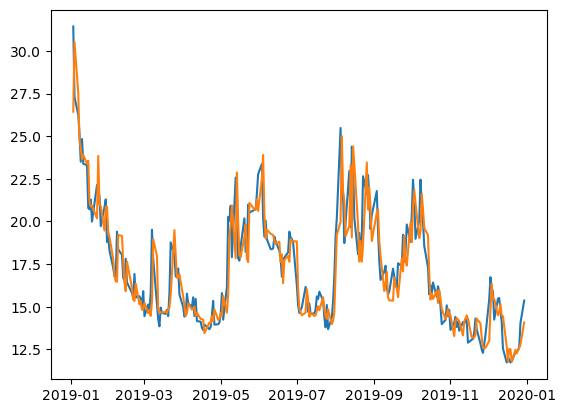

In [161]:
plt.plot(test_dates[1:], y_test[1:])
plt.plot(test_dates[1:], y_pred)

Epoch 1/25
16/16 [==============================] - 5s 8ms/step - loss: 263.7345
Epoch 2/25
16/16 [==============================] - 0s 8ms/step - loss: 253.1385
Epoch 3/25
16/16 [==============================] - 0s 8ms/step - loss: 191.7957
Epoch 4/25
16/16 [==============================] - 0s 8ms/step - loss: 73.6894
Epoch 5/25
16/16 [==============================] - 0s 8ms/step - loss: 25.6604
Epoch 6/25
16/16 [==============================] - 0s 8ms/step - loss: 20.5282
Epoch 7/25
16/16 [==============================] - 0s 8ms/step - loss: 20.2990
Epoch 8/25
16/16 [==============================] - 0s 10ms/step - loss: 19.9930
Epoch 9/25
16/16 [==============================] - 0s 10ms/step - loss: 19.7641
Epoch 10/25
16/16 [==============================] - 0s 10ms/step - loss: 19.5335
Epoch 11/25
16/16 [==============================] - 0s 9ms/step - loss: 18.9901
Epoch 12/25
16/16 [==============================] - 0s 8ms/step - loss: 18.2807
Epoch 13/25
16/16 [============

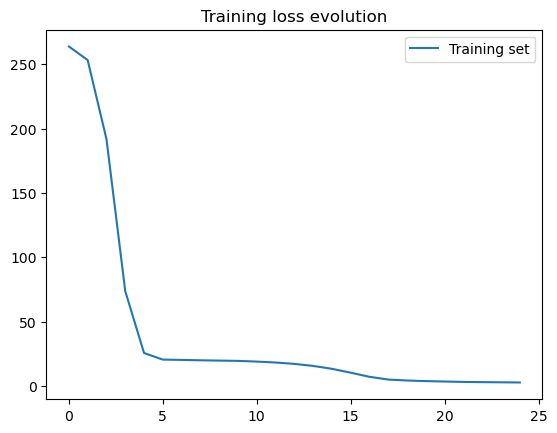

8/8 [==============================] - 1s 4ms/step
RMSE: 1.4070157466184445 R2: 0.8117054045342241


In [162]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_train_daily_2)
X_test_daily_scaled = scaler.transform(X_test_daily_2)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(252, activation='relu', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
#model.add(SimpleRNN(100, return_sequences = False))
model.add(GRU(100, return_sequences = True))
model.add(LSTM(50, return_sequences = False))
#model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='tanh'))
#model.add(Dense(16, activation='relu'))
#model.add(Dropout(0.25))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train[1:], 
    epochs=25, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test[1:], y_pred))
r2_rnn = r2_score(y_test[1:], y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


In [163]:
X_train3 = X_train_daily.copy()
X_train3['inflation'] =  X_train['US_log_inflation_lag1']

In [164]:
X_train3

,Volatility_lag1,stock_returns_lag1,stock_volume_lag1,inflation
1254,18.00,-1.466868,36521300.0,-0.639069
1253,19.05,-1.340836,66205500.0,-0.639069
1252,17.20,1.289125,37577400.0,-0.639069
1251,16.61,1.913960,40212600.0,-0.639069
1250,16.60,-0.658282,41410100.0,-0.639069
...,...,...,...,...
255,32.69,-3.099350,141129400.0,0.068466
254,36.04,-2.479796,56163300.0,0.068466
253,30.50,6.243867,98982100.0,0.068466
252,33.27,0.387000,85824300.0,0.068466


In [165]:
X_test3 = X_test_daily.copy()
X_test3['inflation'] = X_test['US_log_inflation_lag1']

Epoch 1/150
16/16 [==============================] - 6s 11ms/step - loss: 262.3239
Epoch 2/150
16/16 [==============================] - 0s 11ms/step - loss: 238.4582
Epoch 3/150
16/16 [==============================] - 0s 12ms/step - loss: 103.7274
Epoch 4/150
16/16 [==============================] - 0s 12ms/step - loss: 35.9637
Epoch 5/150
16/16 [==============================] - 0s 12ms/step - loss: 28.1006
Epoch 6/150
16/16 [==============================] - 0s 13ms/step - loss: 23.6038
Epoch 7/150
16/16 [==============================] - 0s 12ms/step - loss: 22.0445
Epoch 8/150
16/16 [==============================] - 0s 16ms/step - loss: 17.3644
Epoch 9/150
16/16 [==============================] - 0s 13ms/step - loss: 13.4462
Epoch 10/150
16/16 [==============================] - 0s 16ms/step - loss: 13.6813
Epoch 11/150
16/16 [==============================] - 0s 12ms/step - loss: 12.4954
Epoch 12/150
16/16 [==============================] - 0s 12ms/step - loss: 12.4448
Epoch 13/1

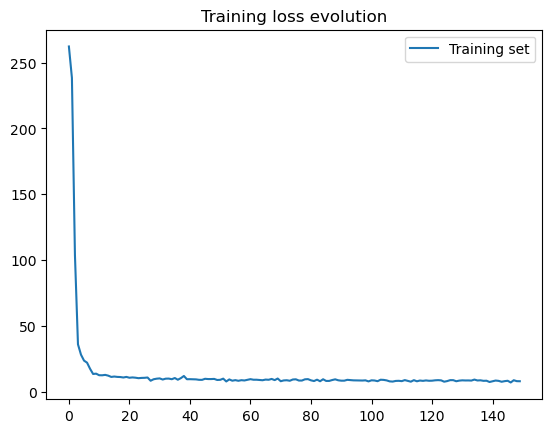

8/8 [==============================] - 1s 5ms/step
RMSE: 1.4802327633088173 R2: 0.7986248721270995


In [166]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_train3)
X_test_daily_scaled = scaler.transform(X_test3)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(252, activation='relu', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
#model.add(SimpleRNN(100, return_sequences = False))
model.add(GRU(100, return_sequences = True))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='tanh'))
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


In [338]:
model.summary()

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_105 (LSTM)             (None, 1, 252)            259056    
                                                                 
 gru_28 (GRU)                (None, 1, 100)            106200    
                                                                 
 lstm_106 (LSTM)             (None, 50)                30200     
                                                                 
 dense_131 (Dense)           (None, 64)                3264      
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_132 (Dense)           (None, 32)                2080      
                                                                 
 dropout_24 (Dropout)        (None, 32)              

In [ ]:
#try including inflation and interest rates? try including just interest rates?


Epoch 1/150
16/16 [==============================] - 7s 15ms/step - loss: 263.9348
Epoch 2/150
16/16 [==============================] - 0s 16ms/step - loss: 255.0322
Epoch 3/150
16/16 [==============================] - 0s 15ms/step - loss: 188.3558
Epoch 4/150
16/16 [==============================] - 0s 15ms/step - loss: 53.7563
Epoch 5/150
16/16 [==============================] - 0s 15ms/step - loss: 24.7412
Epoch 6/150
16/16 [==============================] - 0s 14ms/step - loss: 22.0806
Epoch 7/150
16/16 [==============================] - 0s 14ms/step - loss: 21.9707
Epoch 8/150
16/16 [==============================] - 0s 13ms/step - loss: 21.4614
Epoch 9/150
16/16 [==============================] - 0s 14ms/step - loss: 21.4512
Epoch 10/150
16/16 [==============================] - 0s 15ms/step - loss: 21.6926
Epoch 11/150
16/16 [==============================] - 0s 15ms/step - loss: 22.0343
Epoch 12/150
16/16 [==============================] - 0s 15ms/step - loss: 21.7218
Epoch 13/1

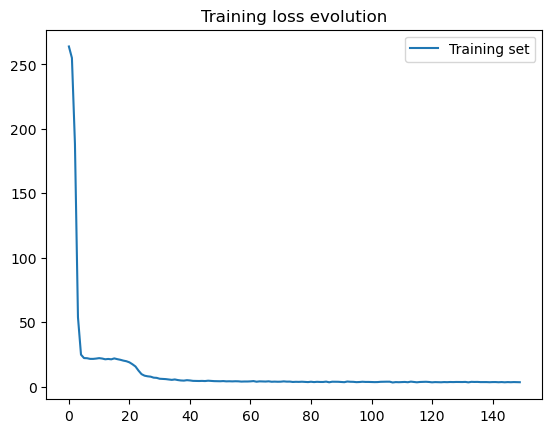

8/8 [==============================] - 2s 4ms/step
RMSE: 1.4240327834513344 R2: 0.8136258056597756


In [167]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(96, activation='tanh', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
model.add(Dropout(0.25))
model.add(LSTM(96, activation='tanh', return_sequences = True))
model.add(Dropout(0.25))
model.add(LSTM(96, activation='tanh', return_sequences = True))
model.add(Dropout(0.25))
model.add(LSTM(96, activation='tanh', return_sequences = False))
model.add(Dropout(0.25))
model.add(Dense(1))

model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')


# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train, 
    epochs=150, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)





In [168]:
X_vollag = X_train['Volatility_lag1']
X_vollag_test = X_test['Volatility_lag1']

In [169]:
X_vollag = np.array(X_vollag).reshape(-1, 1)
X_vollag_test = np.array(X_vollag_test).reshape(-1, 1)

In [170]:
# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'n_estimators': range(70,80), 'max_depth': range(1,5)}, #number of trees in the forest and max depth
    "Gradient Boosting": {'n_estimators': range(75,85), 'learning_rate': np.linspace(0.08,0.12,10), 'max_depth': [1, 2, 3]}
}

# Storing model performance
model_performance2 = {}
model_predictions2 = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]
    print(params)
    
    # Using GridSearchCV for hyperparameter tuning
    param_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5, scoring='neg_mean_squared_error')
    param_search.fit(X_vollag, y_train)

    # Best model
    best_model = param_search.best_estimator_
    
    #Print the best model:
    print(best_model)
    
    # Predict on test set
    y_pred = best_model.predict(X_vollag_test)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Store results
    model_performance2[model_name] = {'RMSE': rmse, 
                                     'R2': r2,
                                     'Best Params': param_search.best_params_}

    # Store predictions to use for visualization:
    model_predictions2[model_name] = {'y_pred' : y_pred}
    
# Output model performance
print(model_performance2)

Model:   Random Forest
{'n_estimators': range(70, 80), 'max_depth': range(1, 5)}
RandomForestRegressor(max_depth=4, n_estimators=73, random_state=42)
Model:   Gradient Boosting
{'n_estimators': range(75, 85), 'learning_rate': array([0.08      , 0.08444444, 0.08888889, 0.09333333, 0.09777778,
       0.10222222, 0.10666667, 0.11111111, 0.11555556, 0.12      ]), 'max_depth': [1, 2, 3]}
GradientBoostingRegressor(learning_rate=0.11555555555555555, max_depth=1,
                          n_estimators=82, random_state=42)
{'Random Forest': {'RMSE': 1.4350105034505116, 'R2': 0.8107412515894961, 'Best Params': {'n_estimators': 73, 'max_depth': 4}}, 'Gradient Boosting': {'RMSE': 1.4060494510310455, 'R2': 0.818303318963231, 'Best Params': {'n_estimators': 82, 'max_depth': 1, 'learning_rate': 0.11555555555555555}}}


In [171]:
X_train.columns

Index(['Volatility_lag1', 'stock_returns_lag1', 'stock_volume_lag1',
       'US_log_inflation_lag1', 'US_interest_rate_lag1',
       'consumer_barometer_lag1'],
      dtype='object')

In [173]:
X_train_novol = X_train[['stock_returns_lag1', 'stock_volume_lag1',
       'US_log_inflation_lag1', 'US_interest_rate_lag1',
       'consumer_barometer_lag1']]
X_test_novol = X_test[['stock_returns_lag1', 'stock_volume_lag1',
       'US_log_inflation_lag1', 'US_interest_rate_lag1',
       'consumer_barometer_lag1']]

In [174]:
# Models to be used
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Hyperparameters for tuning
parameters = {
    "Random Forest": {'n_estimators': range(70,80), 'max_depth': range(1,5)}, #number of trees in the forest and max depth
    "Gradient Boosting": {'n_estimators': range(75,85), 'learning_rate': np.linspace(0.08,0.12,10), 'max_depth': [1, 2, 3]}
}

# Storing model performance
model_performance2 = {}
model_predictions2 = {}

# Tuning hyperparameters and evaluating each model
for model_name in models:
    print('Model:  ', model_name)
    model = models[model_name]
    params = parameters[model_name]
    print(params)
    
    # Using GridSearchCV for hyperparameter tuning
    param_search = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5, scoring='neg_mean_squared_error')
    param_search.fit(X_train_novol, y_train)

    # Best model
    best_model = param_search.best_estimator_
    
    #Print the best model:
    print(best_model)
    
    # Predict on test set
    y_pred = best_model.predict(X_test_novol)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Store results
    model_performance2[model_name] = {'RMSE': rmse, 
                                     'R2': r2,
                                     'Best Params': param_search.best_params_}

    # Store predictions to use for visualization:
    model_predictions2[model_name] = {'y_pred' : y_pred}
    
# Output model performance
print(model_performance2)

Model:   Random Forest
{'n_estimators': range(70, 80), 'max_depth': range(1, 5)}
RandomForestRegressor(max_depth=4, n_estimators=76, random_state=42)
Model:   Gradient Boosting
{'n_estimators': range(75, 85), 'learning_rate': array([0.08      , 0.08444444, 0.08888889, 0.09333333, 0.09777778,
       0.10222222, 0.10666667, 0.11111111, 0.11555556, 0.12      ]), 'max_depth': [1, 2, 3]}
GradientBoostingRegressor(learning_rate=0.08, n_estimators=81, random_state=42)
{'Random Forest': {'RMSE': 3.400290869623893, 'R2': -0.0626198945571419, 'Best Params': {'n_estimators': 76, 'max_depth': 4}}, 'Gradient Boosting': {'RMSE': 3.3402044727384737, 'R2': -0.0253966882806258, 'Best Params': {'n_estimators': 81, 'max_depth': 3, 'learning_rate': 0.08}}}


Epoch 1/50
16/16 [==============================] - 5s 10ms/step - loss: 262.9557
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 249.2378
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 175.6750
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 39.3765
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 23.9895
Epoch 6/50
16/16 [==============================] - 0s 11ms/step - loss: 19.5421
Epoch 7/50
16/16 [==============================] - 0s 12ms/step - loss: 17.6677
Epoch 8/50
16/16 [==============================] - 0s 11ms/step - loss: 15.4185
Epoch 9/50
16/16 [==============================] - 0s 10ms/step - loss: 13.3363
Epoch 10/50
16/16 [==============================] - 0s 11ms/step - loss: 12.1464
Epoch 11/50
16/16 [==============================] - 0s 11ms/step - loss: 11.6647
Epoch 12/50
16/16 [==============================] - 0s 11ms/step - loss: 10.6424
Epoch 13/50
16/16 [===

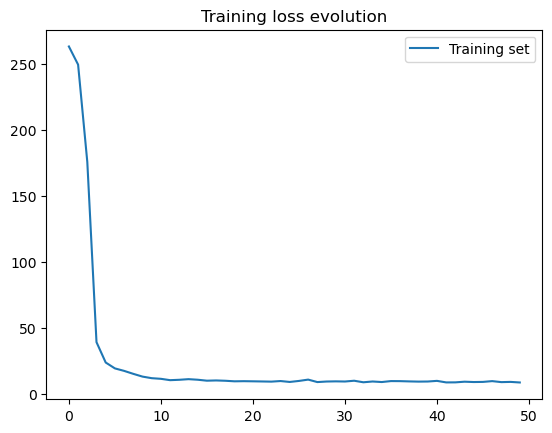

8/8 [==============================] - 1s 4ms/step
RMSE: 1.411209012332309 R2: 0.816967384132684


In [175]:
#try with 252 in lstm thing, maybe thats similar to rolling window?

#' units: Positive integer, dimensionality of the output space.' 
#soo i think not equivalent to window size lol...

#Try RNN:

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_daily_scaled = scaler.fit_transform(X_vollag)
X_test_daily_scaled = scaler.transform(X_vollag_test)

# Reshape input to be [samples, time steps, features]
X_train_daily_scaled = X_train_daily_scaled.reshape((X_train_daily_scaled.shape[0], 1, X_train_daily_scaled.shape[1]))
X_test_daily_scaled = X_test_daily_scaled.reshape((X_test_daily_scaled.shape[0], 1, X_test_daily_scaled.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(252, activation='relu', input_shape=(X_train_daily_scaled.shape[1], X_train_daily_scaled.shape[2]), return_sequences = True))
#model.add(SimpleRNN(100, return_sequences = False))
model.add(GRU(100, return_sequences = True))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='tanh'))
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate = 1e-3, decay=1e-4, clipvalue=1), loss='mean_squared_error')

# Fit the model
history = model.fit(
    X_train_daily_scaled, 
    y_train, 
    epochs=50, 
    batch_size=64, 
    verbose=1)

plt.plot(history.history['loss'])
plt.title("Training loss evolution")
plt.legend(["Training set"])
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_daily_scaled)
rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rnn = r2_score(y_test, y_pred)
print('RMSE:', rmse_rnn, 'R2:', r2_rnn)


In [176]:
merged_df.columns

Index(['Volatility', 'stock_returns', 'stock_volume', 'US_log_inflation',
       'US_interest_rate', 'consumer_barometer', 'Volatility_lag1',
       'stock_returns_lag1', 'stock_volume_lag1', 'US_log_inflation_lag1',
       'US_interest_rate_lag1', 'consumer_barometer_lag1'],
      dtype='object')

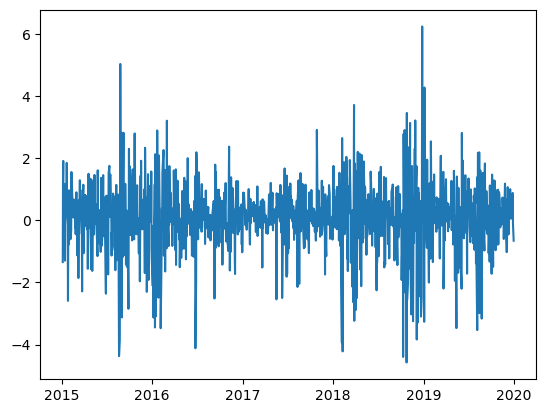

In [179]:
plt.plot(merged_df['stock_returns'])

In [180]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

y_pred = model.predict(X_test_scaled)

Epoch 1/50
26/26 [==============================] - 1s 7ms/step - loss: 196.4343 - val_loss: 268.5711
Epoch 2/50
26/26 [==============================] - 0s 3ms/step - loss: 101.8559 - val_loss: 137.4637
Epoch 3/50
26/26 [==============================] - 0s 3ms/step - loss: 24.2400 - val_loss: 60.7141
Epoch 4/50
26/26 [==============================] - 0s 2ms/step - loss: 14.1941 - val_loss: 48.5864
Epoch 5/50
26/26 [==============================] - 0s 3ms/step - loss: 11.9192 - val_loss: 36.2895
Epoch 6/50
26/26 [==============================] - 0s 3ms/step - loss: 10.3921 - val_loss: 27.8523
Epoch 7/50
26/26 [==============================] - 0s 3ms/step - loss: 9.2126 - val_loss: 19.5675
Epoch 8/50
26/26 [==============================] - 0s 3ms/step - loss: 8.1343 - val_loss: 15.6266
Epoch 9/50
26/26 [==============================] - 0s 2ms/step - loss: 7.2000 - val_loss: 11.1487
Epoch 10/50
26/26 [==============================] - 0s 3ms/step - loss: 6.5772 - val_loss: 8.9894


In [181]:
np.sqrt(mean_squared_error(y_test, y_pred))

3.3533250753441495